In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
np.set_printoptions(suppress=True)

In [2]:
def jd_to_date(jd):    
    '''
    Converts Julian date to Gregorian date.
    From Astronomical Algorithms, Jean Meeus, 1991.
    '''
    import math

    j = jd + 0.5
    z = math.trunc(j)
    f = j - z

    if z < 2299161:
        A = z
    else:
        alpha = int((z - 1867216.25)/36524.25)
        A = z + 1 + alpha - int(alpha/4)

    B = A + 1524
    C = int((B - 122.1)/365.25)
    D = int(365.25 * C)
    E = int((B - D)/30.6001)

    day = B - D - int(30.6001 * E)
    month = E - 1 if E < 14 else E - 13
    year = C - 4716 if month > 2 else C - 4715

    # added by me to calculate hours, minutes, seconds.
    h = int(f * 24)
    m = int((f * 24 - int(h)) * 60)
    s = int((((f * 24 - int(h)) * 60) - m) * 60)

    return year, month, day, h, m, s



def date_to_jd(date, time):    
    '''
    Converts Gregorian date to Julian date given the format:
    date = YYYY-MM-DD, time = HH:MM:SS
    From Astronomical Algorithms, Jean Meeus, 1991.
    '''
    x = time.split(':')
    x = [int(xi) for xi in x]
    s = x[2]
    mi = x[1]
    h = x[0]
    f = h/24 + mi/(60*24) + s/3600
    
    sign = 1
    if date[0] == '-':
        date = date[1:]
        sign = -1
    x = date.split('-')
    x = [int(xi) for xi in x]
    d = x[2]
    mo = x[1]
    y = sign * x[0]
    
    earlyOct1582 = (y==1582 and mo<=10 and d < 15)
    early1582 = (y==1582 and mo<= 9)
    anytimeBefore = (y < 1582)
    
    if earlyOct1582 or early1582 or anytimeBefore:
        flag = 'J'
    else: 
        flag = 'G'

    if mo == 1 or mo == 2:
        y = y - 1
        mo = mo + 12
    
    A = int(y / 100)
    B = 2 - A + int(A / 4) if flag=='G' else 0

    jd = int(365.25 * (y + 4716)) + int(30.6001 * (mo + 1)) + d + B - 1524.5 + f
    
    return jd



def get_moon_phase(now):
    '''
    Calculate moon phase for a given Julian date.(cf. Chapman & Linzen)
    ---INPUT---
        now: a Julian date, including hours, minutes, seconds.
    ---OUTPUT---
        nuHrs: Phase of the moon in hours
    '''
    from math import pi
    
    ref = date_to_jd('1899-12-31', '12:00:00')
    T = (now - ref) / 36525
    nu = -9.26009 + 445267.12165*T + 0.00168*(T**2)
    ageDeg = nu % 360
    nuRad = ageDeg * pi / 180
    nuHrs = (nu/15) % 24
    return nuHrs


def generate_tides(startDate, endDate, amps, phase, dt=1, longIncr=15, 
                   nRange=range(1,3), sRange=range(-6,7), filename='tides.txt',
                   component='solar'):
    '''
    Generates tidal data using the equation:
    A + ΣΣS_{ns}*cos[Ωnt + sλ - Φ_{ns}] + ΣΣL_{ns}*cos[Ωnt + sλ - Φ_{ns}]
    for specified amplitudes and phases. 
    This function is altitude and latitude independent (***???)
    where 
        A = amplitude
        n = 2nd harmonic (semidiurnal variation)
        s = zonal wavenumber (maxes and mins along a line of longitude)
            s = 2 => migrating tide
            s = 3 => non-migrating tide
        t = universal time at Greenwich Meridian
        λ = longitude
        Φ = phase
    --INPUT--
        startDate       a start date, format '2016-06-21'
        endDate         an end date, format '2016-06-30'
        amps            List of amplitude values (length = 3).
        phase           info about whether to vary phase or keep it cosntant
        nRange          values of n to use in calculation
        sRange          values of s to use in calculation
        filename        filename to write values to
        component       solar, lunar, s+l (solar+lunar) or all; specifies 
                        summation bounds for n and s
    --OUTUT--
        Tidal data in array of format:
        Solar local time - Lunar local time - Longitude - Solar Julian date - 
        Lunar Julian date - Hour of day - Moon phase in hours - Tidal value
        
    Adapted from script by Dr. Ruth Lieberman by Eryn Cangi for LASP REU 2016.
    '''
    from math import pi, cos
    
    # VARIABLES --------------------------------------------------------------
    A = amps[0]                    # Background amplitude
    S = amps[1]                    # Solar amplitude
    L = amps[2]                    # Lunar amplitude
    if phase=='C':                 # Phases (Φ_{n,s})
        phi = 0
    else:
        phi = lambda t: cos(t + pi/2)
    hoursPerDay = 24 
     
    # DEFINE LONGITUDE GRID --------------------------------------------------
    numLongs = 360 // longIncr
    longs = np.asarray([l*pi/180 for l in list(range(-180, 180, longIncr))])
    W = 2*pi/24                   # Earth rotation rate (omega)
    
    # GET JULIAN DATES -------------------------------------------------------
    ti = date_to_jd(startDate, '00:00:00')
    tf = date_to_jd(endDate, '00:00:00')
    numDays = int(tf - ti) + 1 # +1 to include the last day in the loops
    
    # MAKE OUTPUT ARRAY ------------------------------------------------------
    rows = numLongs * 24/dt * numDays
    output = np.empty([rows,7])
    r = 0
    
    # LOOP THROUGH TIMESPAN (DAYS) ===========================================
    for day in range(numDays):    # + makes inclusive: calculates for last day
        curJulDate = ti + day
        
        # GET REGULAR DATE FOR CALCULATIONS ----------------------------------
        yr, mo, d, h, minute, sec = jd_to_date(curJulDate) 
        curRegDate = '{}-{:>02}-{:>02}'.format(yr, mo, d)
        curRegHour = h
        
        # LOOP THROUGH HOURS IN DAY ==========================================
        for hr in np.arange(hoursPerDay):
            for f in np.arange(0,1,dt):

                # UPDATE HOUR, GET NEW JULIAN DATE -------------------------------
                curRegHour = 0 + hr
                curRegMin = int(f * 60)
                fracHr = curRegHour + f
                curRegTime = '{:>02}:{:>02}:{:>02}'.format(curRegHour, curRegMin, sec)
                newJD = date_to_jd(curRegDate, curRegTime)

                # GET MOON PHASE AT THIS HOUR ------------------------------------
                nuHrs = get_moon_phase(newJD)

                # LOOP OVER LONGITUDES ===========================================
                for l in longs:
                    # CALCULATE SOLAR LOCAL TIME ---------------------------------
                    slt = fracHr + l/W
                    if slt < 0:            # Wrap around behavior, Earth = sphere
                        slt = slt + 24
                    elif slt > 24:
                        slt = slt - 24
                    else:
                        pass

                    # CALCULATE LUNAR LOCAL TIME ---------------------------------
                    llt = slt - nuHrs
                    llt = llt + 24 if llt < 0 else llt

                    # CALCULATE THE TIDES ----------------------------------------

                    # Assign amplitudes
                    # Background
                    if type(A)==int:
                        tide = A
                    else:
                        tide = A(hr,l)

                    # Solar
                    if type(S)==int:
                        A_S = S
                    else:
                        A_S = S(hr,l)

                    # Lunar
                    if type(L)==int:
                        A_L = L
                    else:
                        A_L = L(hr,l)

                    # Assign phase 
                    if type(phi)==int:
                        p = phi
                    else:
                        p = phi(hr)

                    for n in nRange:
                        for s in sRange:
                            if component=='solar':     # solar contribution
                                # DO NOT CHANGE-----------------------------------
                                tide += A_S * cos((2*pi*n/24)*fracHr + s*l - p)
                                #-------------------------------------------------
                            elif component=='lunar':   # lunar contribution
                                tide += A_L * cos((2*pi*n/24)*(fracHr-nuHrs) + s*l - p)

                            elif component=='s+l':
                                tide += A_S*cos((2*pi*n/24)*fracHr + s*l - p) \
                                      + A_L*cos((2*pi*n/24)*(fracHr-nuHrs) + s*l - p)
                    output[r,0] = slt
                    output[r,1] = llt
                    output[r,2] = round(l * 180/pi)
                    output[r,3] = newJD
                    output[r,4] = fracHr
                    output[r,5] = nuHrs
                    output[r,6] = tide
                    r += 1

    # FORMAT HEADER LINE, WRITE FILE -----------------------------------------
    cells = '{:^20}'*7            
    line0 = cells.format('Solar local time', 'Lunar local time', 'Longitude', 
                        'Julian Date', 'UT', 'Moon phase (hrs)', 'Tide')
    np.savetxt(filename, output, fmt='%.4f', delimiter='\t', header=line0)
    
    return output



def bin_by_solar(data, filename):
    '''
    Finds the mean of the solar contribution at a given solar local time.
    Writes a file of means for each pair of a unique solar local time and
    longitude.
    ---INPUT---
        data        Array of tidal data
        filename    Name for output file
    ---OUTPUT---
        means       3-column array, columns: solar local time, longitude,
                    mean solar contribution.
    '''

    means = []

    # FIND UNIQUE SOLAR LOCAL TIMES ------------------------------------------
    slt = np.ndarray.tolist(data[:,0])
    unique_slt = set([round(x,4) for x in slt])

    # ITERATE OVER SOLAR LOCAL TIMES & LONGITUDES ----------------------------
    for val in unique_slt:
        for lon in range(-180, 180, 15):
            sltSlice = data[np.where(data[:,0] == val)]
            sltSlice = sltSlice[np.where(sltSlice[:,2]==lon)]
            if sltSlice.size != 0:
                means.append([val, lon, np.mean(sltSlice[:,6])])
                
    means = np.asarray(means)

    return means
    

def remove_solar(original, means): 
    '''
    Subtract off the solar tidal averages. Iterates through the file holding 
    solar tidal average data per solar local time and longitude.
    --INPUT--
        original    Data array where columns are solar local time, lunar local
                    time, longitude, lunar Julian date, hour, moon phase and 
                    total tidal value.
        means       Data array containing SLT, longitude and mean tidal value.
    --OUTPUT--
        result      Array holding original data for columns 0-5 and the 
                    "reconstructed" lunar tidal values in column 6
    '''
    
    # create new array to store subtracted values
    #r = np.zeros([original.shape[0]])
    
    # create copy arrays
    solar_to_subtract = np.array(original)
    difference = np.array(original)

    # For each SLT and longitude pair, find row in original data where solar 
    # local time and longitude match. Then subtract the solar tidal data
    for row in means:
        slt = row[0]
        long = row[1]
        avg = row[2]
        # find rows in original data that match
        i = np.where((original[:,0]==slt) & (original[:,2]==long))[0]
        solar_to_subtract[i,6] = avg
        difference[i,6] = original[i,6] - avg
            
    return solar_to_subtract, difference


def chisq(obs, exp):
    '''
    Perform χ² minimization test for the observed and expected lunar tidal 
    data.
    '''
    tot = 0

    for o,e in zip(obs, exp):
        chisq = (o-e)**2 / e
        tot += chisq

    print(tot)


def plot_vs_long(data, date, time, flag, title, c):
    '''
    Plots tidal value versus longitude for a specified Julian date
    ---INPUT---
        data        Array of tidal data
        date        date in format YYYY-MM-DD
        time        time in format HH:MM:SS
        flag        'save' or 'show', controls how the plot is handled.
        title       descriptive plot title
        c           plot line color. Just for aesthetics.
    ---OUTPUT---
        A plot
    '''
    
    
    JDdate = date_to_jd(date, time)

    # FIND ROWS IN DATA ARRAY WITH MATCHING DATE -----------------------------
    # Because data for a particular Julian date is all grouped together, the 
    # values in rows[0] (the indices) will be consecutive.
    rows = np.where(data[:,3]==JDdate)[0]
    i = rows[0]
    f = rows[-1]
    longs = data[i:f,2]
    tides = data[i:f,6]
    
    # PLOT -------------------------------------------------------------------
    plt.figure(figsize=(10,8))
    plt.plot(longs, tides, color=c, marker=r'$\bigodot$', markersize=12)
    plt.title('{}, {} at {}'.format(title, date, time))
    plt.xlabel('Longitude')
    plt.ylabel('Tide amplitude') # what actually is the units of this?
    plt.rcParams.update({'font.size': 16})
    
    if flag=='show':
        plt.show()
        plt.close()
    elif flag=='save':
        fn = 'tides_d{}_{:>02}.png'
        plt.savefig(fn.format(date, time.split(':')[0]), bbox_inches='tight')
        plt.clf()
        plt.close()
    
      
def plot_vs_date(data, long, title, data2=None, c=None, m=None, lb=None, mode='show'):
    '''
    Plots tidal values over time at a particular longitude.
    ---INPUT---
        data        Array of tidal data
        long        Longitude to examine
        title       descriptive plot title
        data2       Optional second data to plot if stacking two tides
        c           color list, has two elements if stacking.
        m           marker shape to use
        lb          Plot legend elements
        mode        Whether to save or show the figure. Default 'show'
    ---OUTPUT---
        A plot
    '''
    
    if data2 != None:
        stack = True
    else: 
        stack = False
        
    # FIND ROWS IN ARRAY WITH MATCHING LONGITUDE -----------------------------
    rows = np.where(data[:,2]==long)[0]
    times = [data[i, 3] for i in rows]
    tides = [data[i, 6] for i in rows]
    
    if stack:
        tides2 = [data2[i,6] for i in rows]
    

    # PLOT -------------------------------------------------------------------
    plt.figure(figsize=(25,6))
    s = len(times)                           # set a limit for plotting
    
    if stack:
        plt.plot(times[:s], tides[:s], color=c[0], marker=m, label=lb[0])
        plt.plot(times[:s], tides2[:s], color=c[1], marker=m, label=lb[1])
        plt.legend(loc='lower right')
    else:
        plt.plot(times, tides, marker=m)
    plt.title('{} by Julian date at {}° Longitude'.format(title, long))
    plt.xlim([min(times),max(times)])
    plt.xlabel('Julian date')
    plt.ylabel('Tide amplitude') # what actually is the units of this?
    plt.rcParams.update({'font.size': 16})
    
    if mode=='show':
        plt.show()
        plt.close()
    elif mode=='save':
        fn = '{} by Julian date at {}° Longitude'.format(title, long)
        plt.savefig(fn, bbox_inches='tight')
        plt.close()
    elif mode=='both':
        fn = '{} by Julian date at {}° Longitude'.format(title, long)
        plt.savefig(fn, bbox_inches='tight')
        plt.show()
        plt.clf()
        plt.close()


def plot_vs_slt(data, time):
    '''
    Plots tidal value versus solar local time
    ---INPUT---
        data        Array of tidal data
        time        time in format HH:MM:SS
    ---OUTPUT---
        A plot
    '''
    
    # FORMAT SLT -------------------------------------------------------------
    time_els = time.split(':')
    time_els = [float(s) for s in time_els]
    time = time_els[0] + time_els[1] / 60 + time_els[2] / 3600

    # CHECK FOR BADLY FORMATTED DECIMALS -------------------------------------
    if time % time_els[0] not in [0, 0.3333, 0.6667]:
        raise Exception('Bad time given')

    # FIND MATCHING SOLAR LOCAL TIMES IN DATA --------------------------------           
    rows = np.where(data[:,0]==time)[0]
    longs = [data[i,2] for i in rows]
    tides = [data[i,6] for i in rows]
    
    # PLOT--------------------------------------------------------------------
    plt.figure(figsize=(10,8))
    plt.scatter(longs,tides, marker='x')
    plt.title('Longitudes vs tides at solar local time {}'.format(time))
    plt.xlabel('Longitude')
    plt.ylabel('Tide value') # what actually is the units of this?
    plt.rcParams.update({'font.size': 16})
    plt.show()
    
    
def bin_by_lunar(data, filename):
    '''
    Finds the mean of the solar contribution at a given solar local time.
    Writes a file of means for each pair of a unique solar local time and
    longitude.
    ---INPUT---
        data        Array of tidal data
        filename    Name for output file
    ---OUTPUT---
        means       3-column array, columns: solar local time, longitude,
                    mean solar contribution.
    '''

    means = []

    # FIND UNIQUE SOLAR LOCAL TIMES ------------------------------------------
    llt = np.ndarray.tolist(data[:,1])
    unique_llt = set([round(x,4) for x in llt])
    print('Unique lunar local times: {}'.format(len(unique_llt)))
    print('Length of lunar local times: {}'.format(len(data[:,1])))

    # ITERATE OVER LUNAR LOCAL TIMES & LONGITUDES ----------------------------
    for val in unique_llt:
        for lon in range(-180, 190, 15):
            lltSlice = data[np.where(data[:,1] == val)]
            lltSlice = lltSlice[np.where(lltSlice[:,2]==lon)]
            if lltSlice.size != 0:
                means.append([val, lon, np.mean(lltSlice[:,6])])
                
    print('Done iterating over LLT...')
    
    means = np.asarray(means)
        
    line0 = 'Lunar Local Time\tLongitude\tMean Lunar Tide'
    np.savetxt('{}_llt_bin.txt'.format(filename), means, fmt='%.4f', delimiter='\t', 
               header=line0)

    return means

# 1 July 2016

So, something weird happened with my previous notebook and I lost all my notes from 30 June afternoon. Luckily I had saved a version of the notebook on github at noon so I recovered much of what was apparently lost (which was 2 days worth). So instead of losing 2 days I only lost a half day. Thankfully.

Lesson learned, though. Will be backing up with git all the time and keeping this notebook a little more basic. I think the notebook extensions may have been causing problems.

So, moving forward, here's what I need to look at.

To do
1. Go through Ruth's no_gaps script and see if I can glean anythng useful from it. 
2. Re-run the comparison plots of SW2 and subtracted, SW2 and averages, original data, etc.
3. Experiment by looking at different time step sizes and longitudes with SW2 only and its average to see if the spikes appear
4. Pick one longitude and universal time and look at the numerical values. Calculate the expectation by hand... see if they make sense

## Various lunar tide plots with different time steps:

<img src="pics/Lunar tides, dt = 12 minutes, by Julian date at -120° Longitude.png" />
<img src="pics/Lunar tides, dt = 15 minutes, by Julian date at -120° Longitude.png" />
<img src="pics/Lunar tides, dt = 60 minutes, by Julian date at -120° Longitude.png" />

## Comparing original solar values to solar subtracted values:

/home/emc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:168: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/emc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:407: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


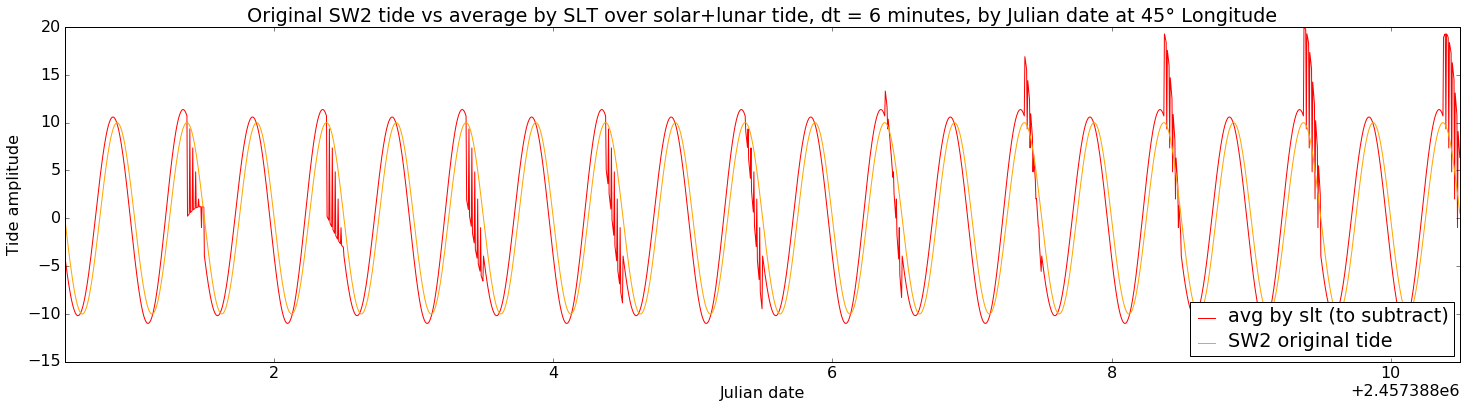

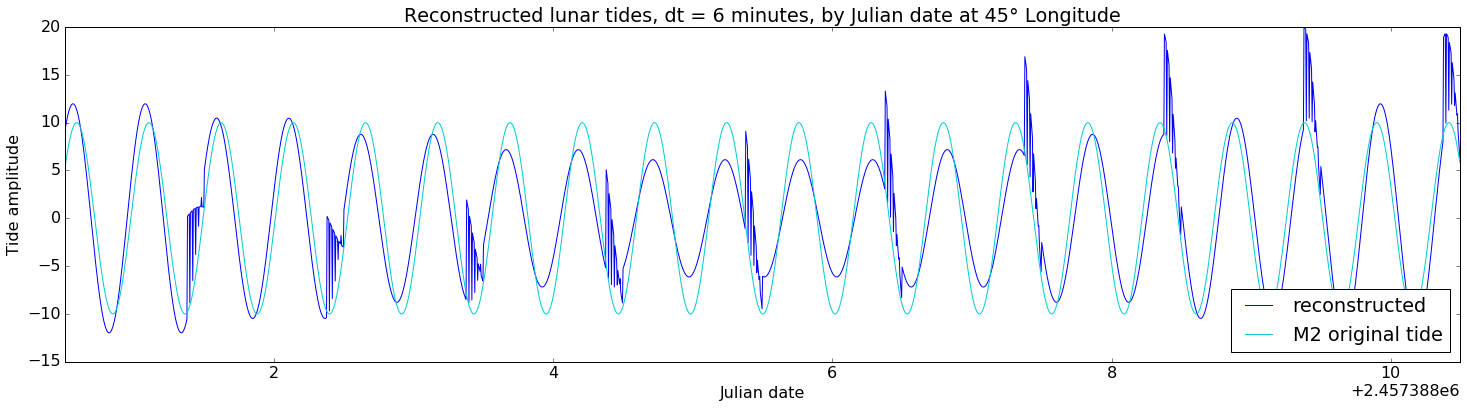

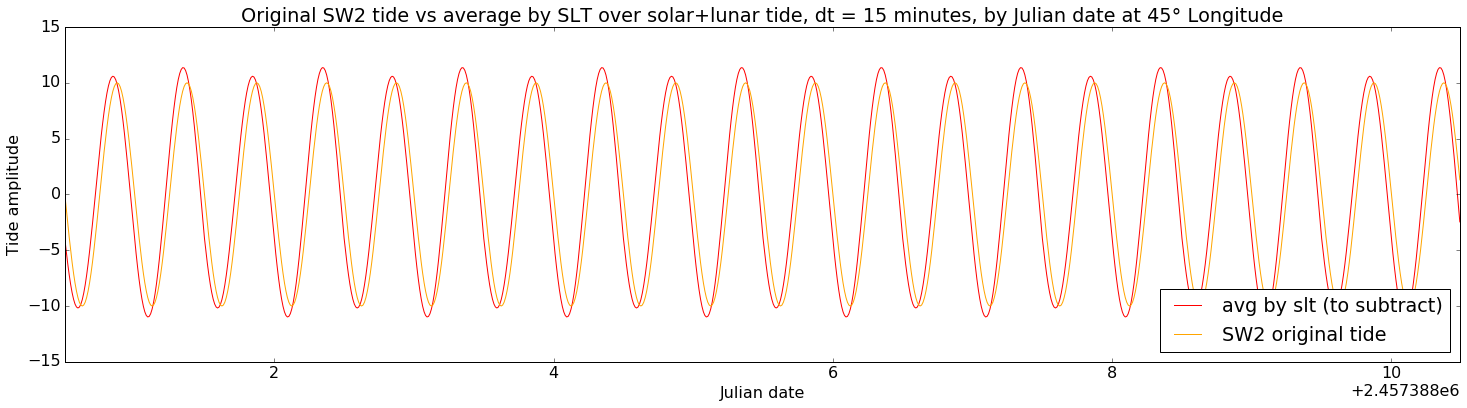

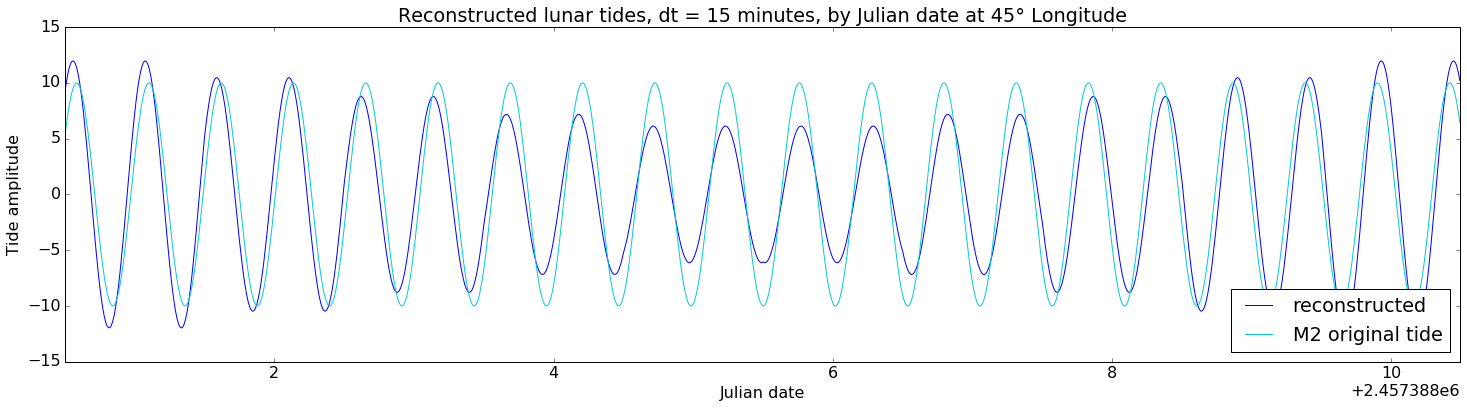

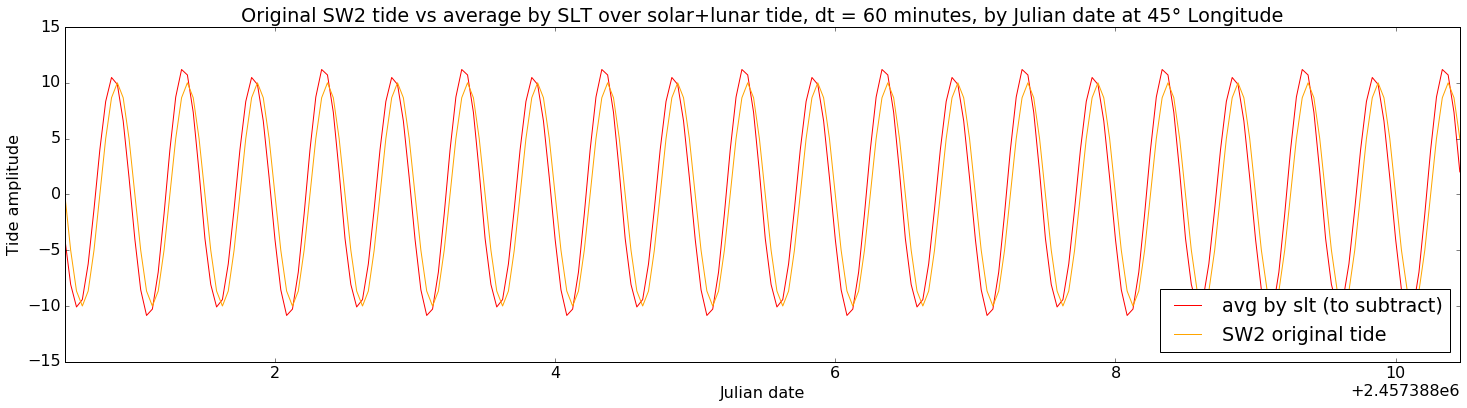

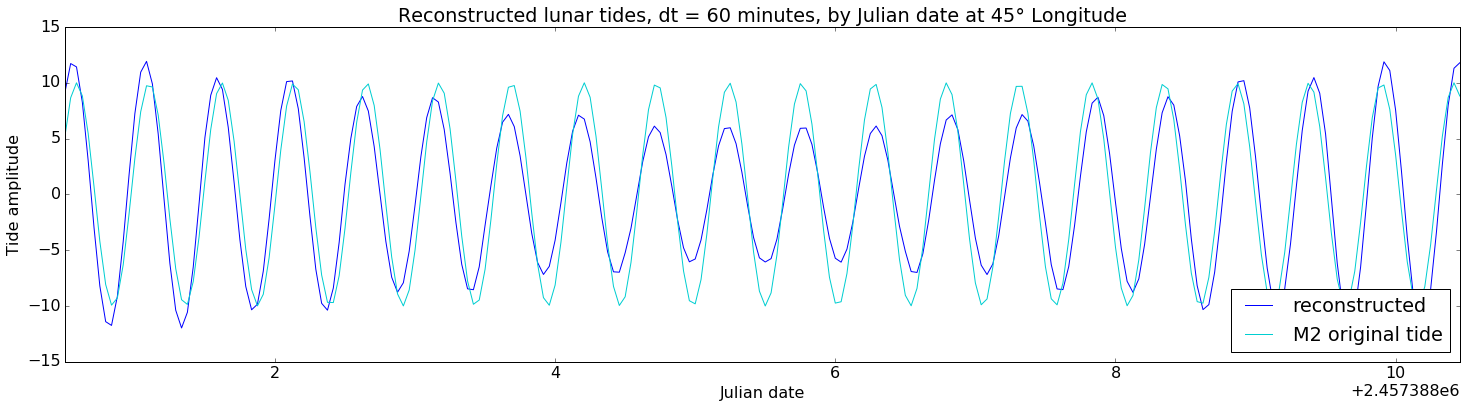

In [2]:
for dt in [0.1, 0.25, 1]:

    #============================================================================#
    # Generate SW2 data
    # Background = 0, Constant amplitude and phase
    #============================================================================#
    data1S = generate_tides('2016-01-01', '2016-01-10', amps=[0,10,10], phase='C',
                            dt=dt, nRange=[2], sRange=[2], filename='SW2_scenario1.txt', 
                            component='solar')

    #============================================================================#
    # Generate M2 data
    # Background = 0, Constant amplitude and phase
    #============================================================================#
    data1L = generate_tides('2016-01-01', '2016-01-10', amps=[0,10,10], phase='C',
                            dt=dt, nRange=[2], sRange=[2], filename='M2_scenario1.txt', 
                            component='lunar')

    #============================================================================#
    # Generate total data
    # Background = 0, Constant amplitude and phase
    #============================================================================#
    data1T = generate_tides('2016-01-01', '2016-01-10', amps=[0,10,10], phase='C',
                            dt=dt, nRange=[2], sRange=[2], filename='TT_scenario1.txt', 
                            component='s+l')

    # Bin by solar local time
    means1T = bin_by_solar(data1T, '1T')

    # Subtract the averages according to solar local time
    subtractedValues, nosol1T = remove_solar(data1T, means1T)

    # Compare input solar to solar averages
    plot_vs_date(subtractedValues, 45, 'Original SW2 tide vs average by SLT over solar+lunar tide, '
                'dt = {} minutes,'.format(int(dt*60)), data2=data1S, 
                c=['red', 'orange'], lb=['avg by slt (to subtract)','SW2 original tide'], 
                mode='show')

    # Compare difference of total and solar averages with lunar
    plot_vs_date(nosol1T, 45, 'Reconstructed lunar tides, '
                'dt = {} minutes,'.format(int(dt*60)), data2=data1L, 
                c=['blue', 'darkturquoise'], lb=['reconstructed','M2 original tide'], 
                mode='show')
    
    print('=============================================================================================')

We expect that the averages above are off because they are computed from data that includes lunar tides. BUT, we don't know why those weird spikes are appearing.

## Compare the solar averages (values to be subtracted) to the original total data:

/home/emc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:168: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/emc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:407: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


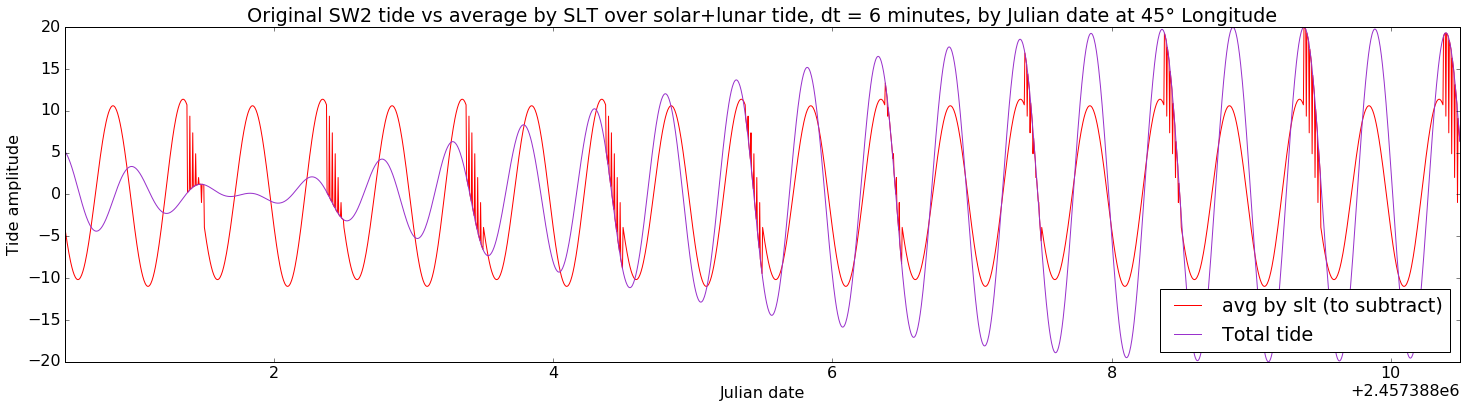

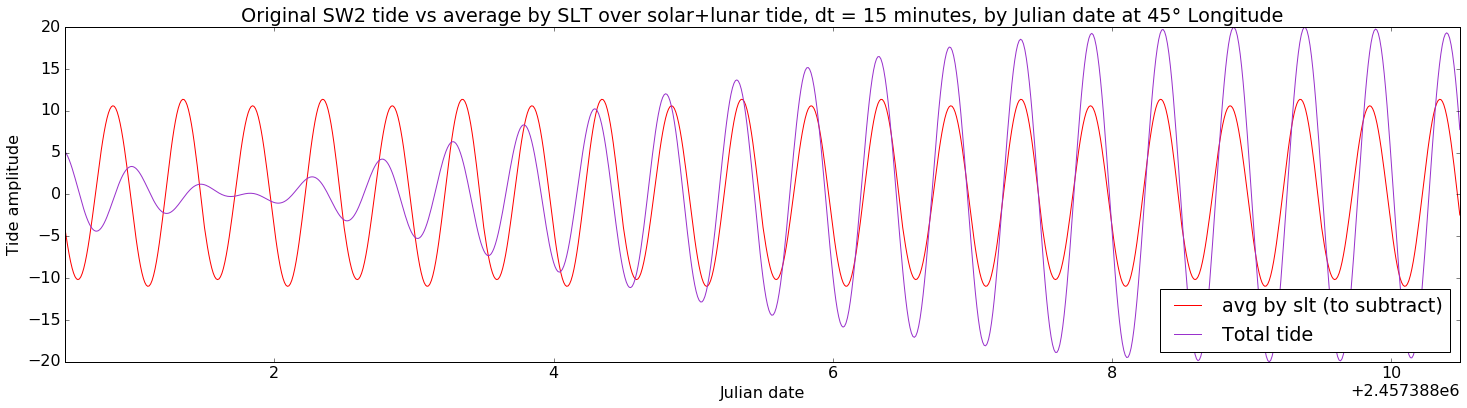

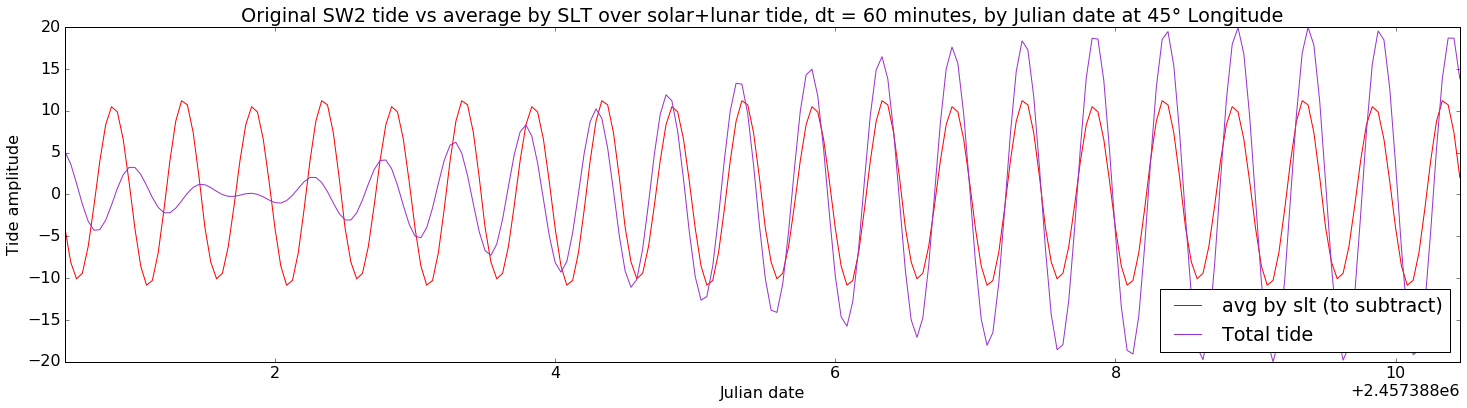

In [3]:
for dt in [0.1, 0.25, 1]:

    #============================================================================#
    # Generate SW2 data
    # Background = 0, Constant amplitude and phase
    #============================================================================#
    data1S = generate_tides('2016-01-01', '2016-01-10', amps=[0,10,10], phase='C',
                            dt=dt, nRange=[2], sRange=[2], filename='SW2_scenario1.txt', 
                            component='solar')

    #============================================================================#
    # Generate M2 data
    # Background = 0, Constant amplitude and phase
    #============================================================================#
    data1L = generate_tides('2016-01-01', '2016-01-10', amps=[0,10,10], phase='C',
                            dt=dt, nRange=[2], sRange=[2], filename='M2_scenario1.txt', 
                            component='lunar')

    #============================================================================#
    # Generate total data
    # Background = 0, Constant amplitude and phase
    #============================================================================#
    data1T = generate_tides('2016-01-01', '2016-01-10', amps=[0,10,10], phase='C',
                            dt=dt, nRange=[2], sRange=[2], filename='TT_scenario1.txt', 
                            component='s+l')

    # Bin by solar local time
    means1T = bin_by_solar(data1T, '1T')

    # Subtract the averages according to solar local time
    subtractedValues, nosol1T = remove_solar(data1T, means1T)

    # Compare input total to solar averages
    plot_vs_date(subtractedValues, 45, 'Original SW2 tide vs average by SLT over solar+lunar tide, '
                'dt = {} minutes,'.format(int(dt*60)), data2=data1T, 
                c=['red', 'darkorchid'], lb=['avg by slt (to subtract)','Total tide'], 
                mode='show')

    
    print('=============================================================================================')

## Check timestep size with SW2 original and its average

/home/emc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:168: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/emc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:407: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


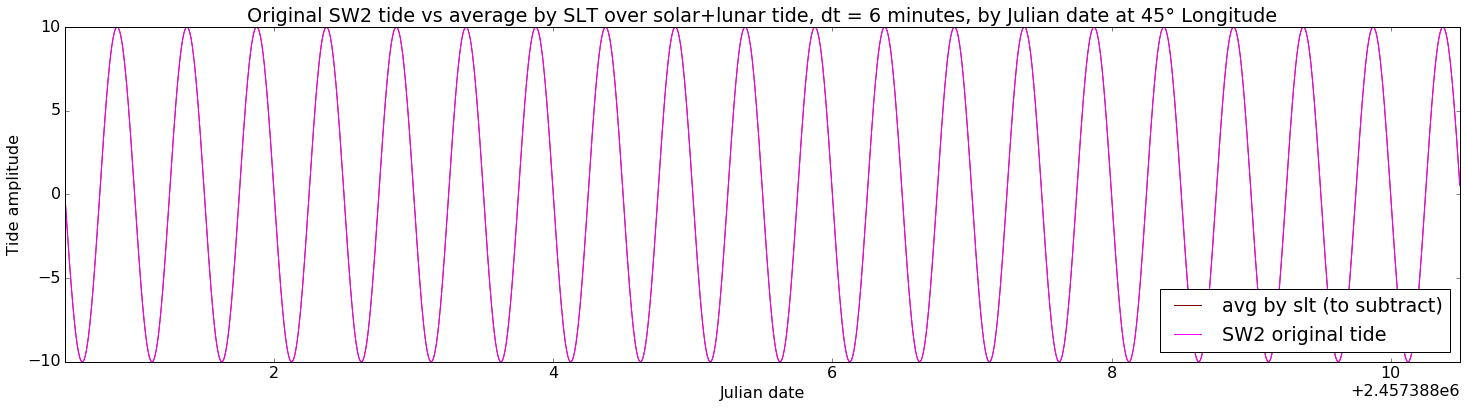

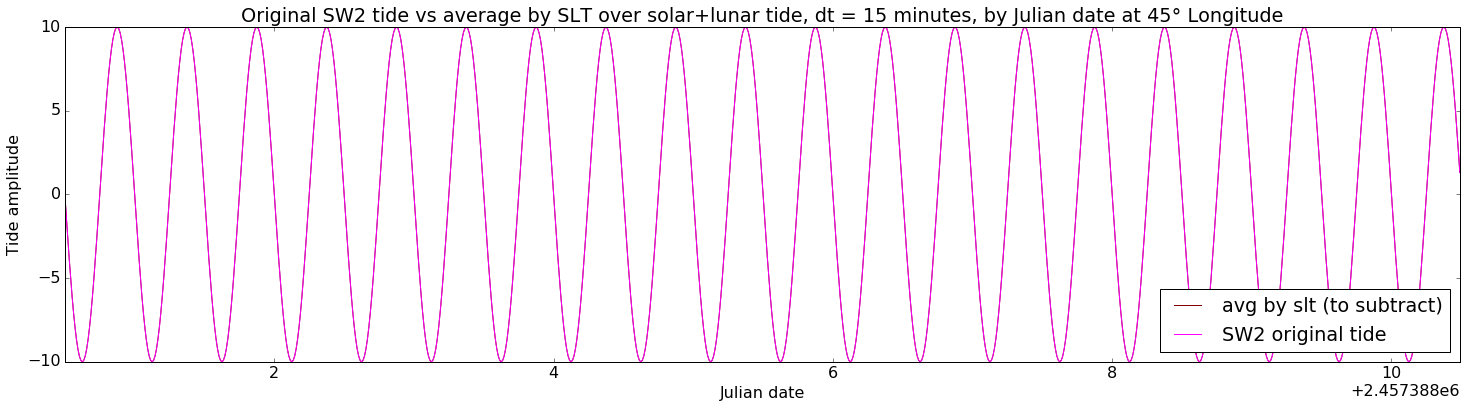

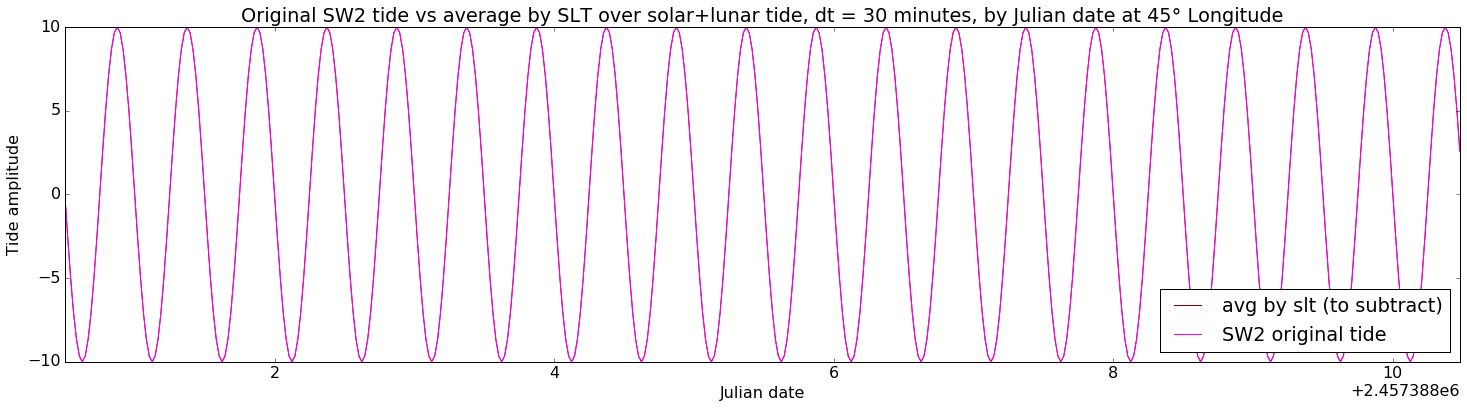

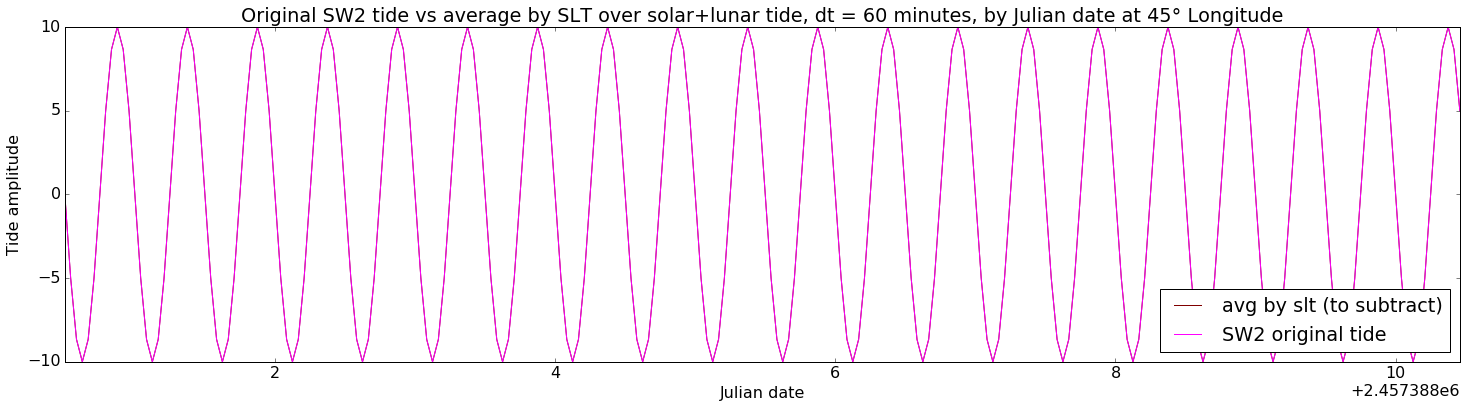

In [5]:
for dt in [0.1, 0.25, 0.5, 1]:

    #============================================================================#
    # Generate SW2 data
    # Background = 0, Constant amplitude and phase
    #============================================================================#
    data1S = generate_tides('2016-01-01', '2016-01-10', amps=[0,10,10], phase='C',
                            dt=dt, nRange=[2], sRange=[2], filename='SW2_scenario1.txt', 
                            component='solar')


    # Bin by solar local time
    means1S = bin_by_solar(data1S, '1T')

    # Subtract the averages according to solar local time
    subtractedValues, nosol1S = remove_solar(data1S, means1S)

    # Compare input total to solar averages
    plot_vs_date(subtractedValues, 45, 'Original SW2 tide vs average by SLT over solar+lunar tide, '
                'dt = {} minutes,'.format(int(dt*60)), data2=data1S, 
                c=['maroon', 'magenta'], lb=['avg by slt (to subtract)','SW2 original tide'], 
                mode='show')

    
    print('=============================================================================================')

Okay - that all looks fine and good for time step variation. What about longitudes? The troublesome value was dt = 0.1 so I will use that.

/home/emc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:168: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/emc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:407: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


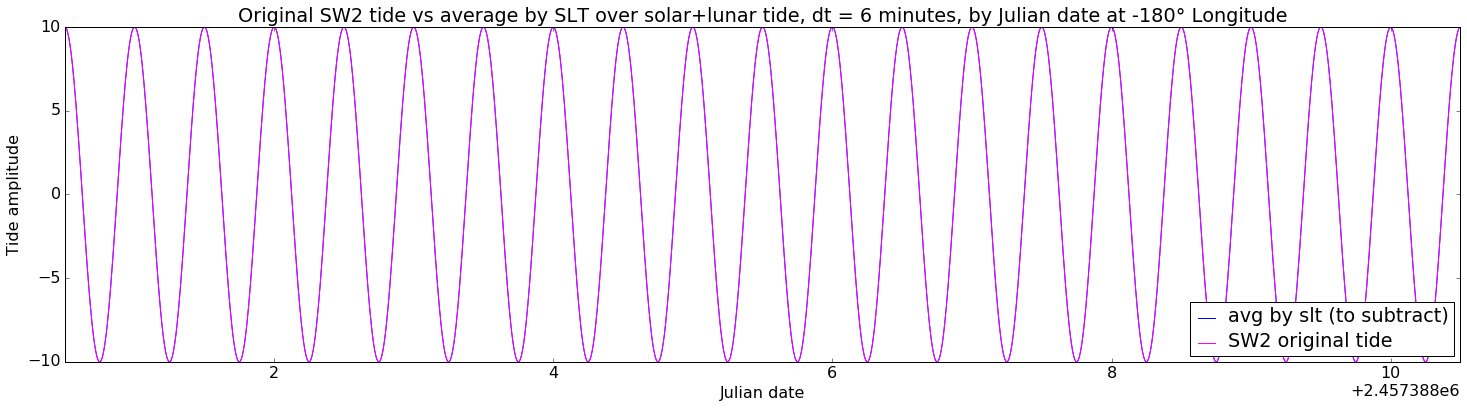

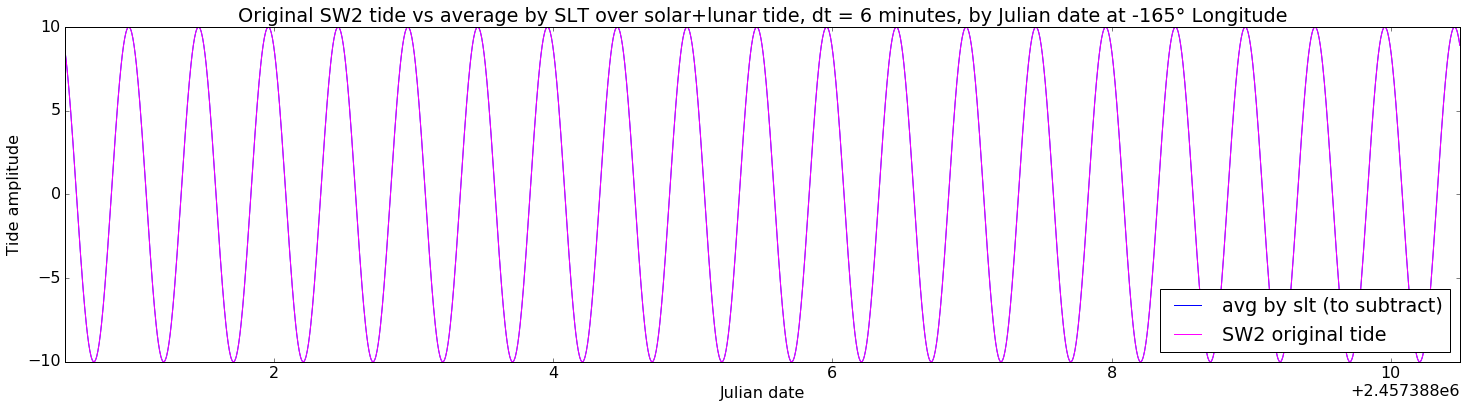

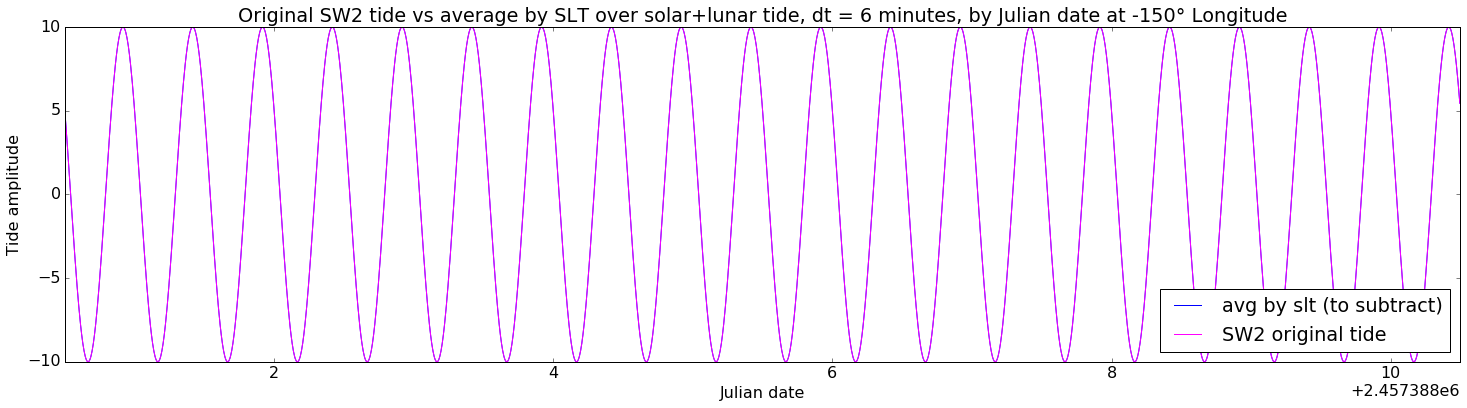

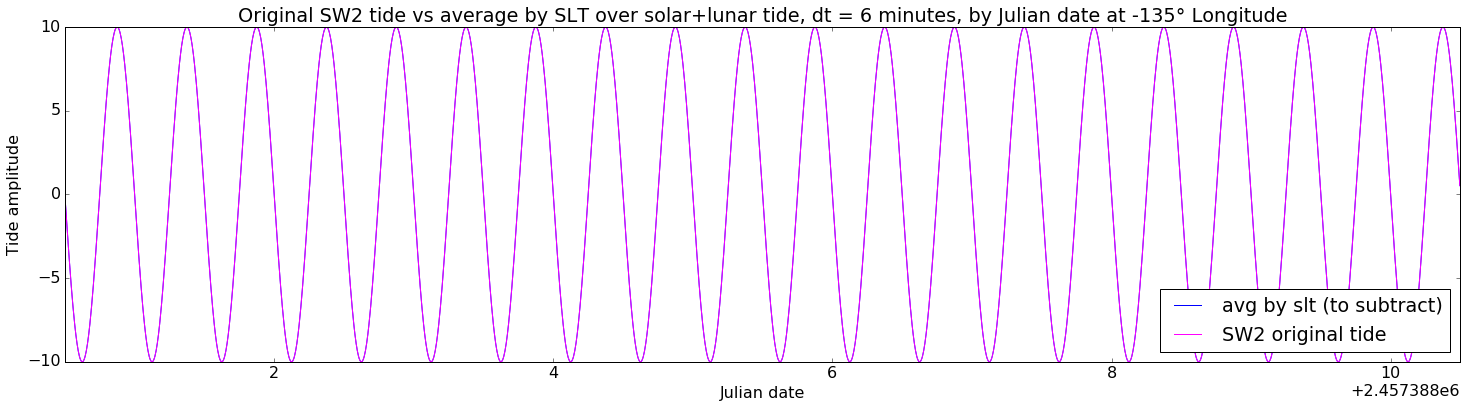

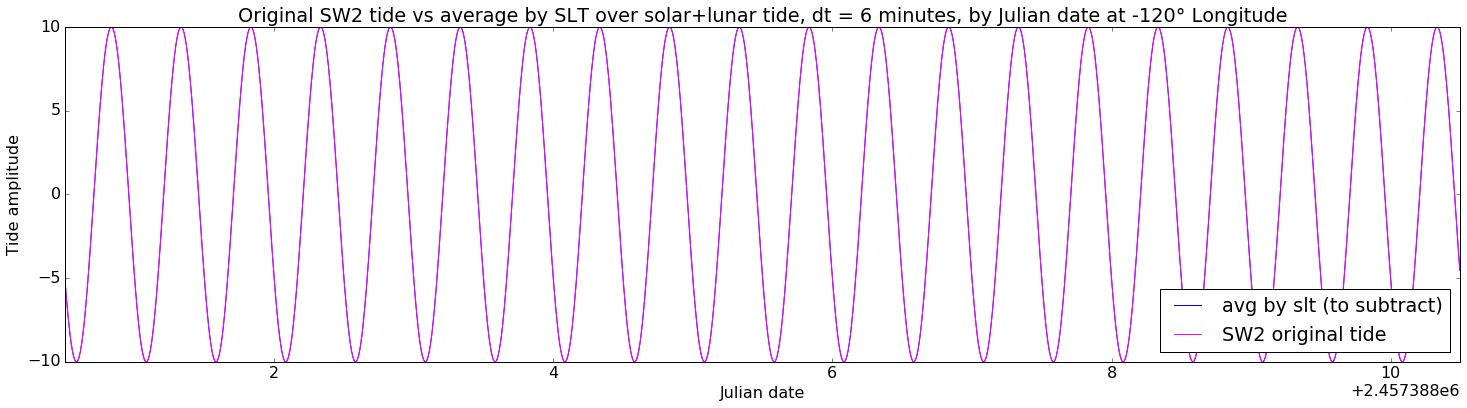

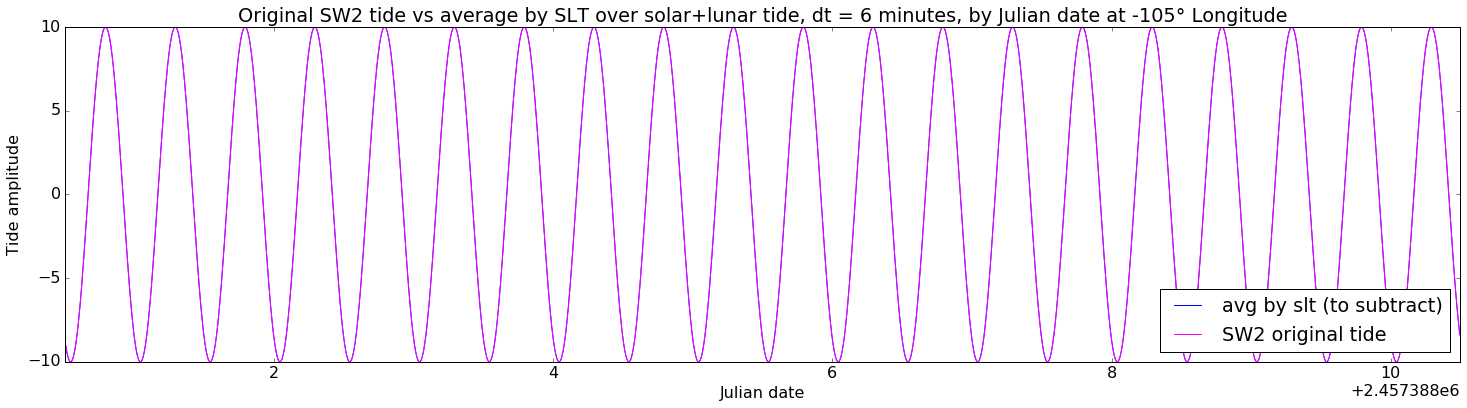

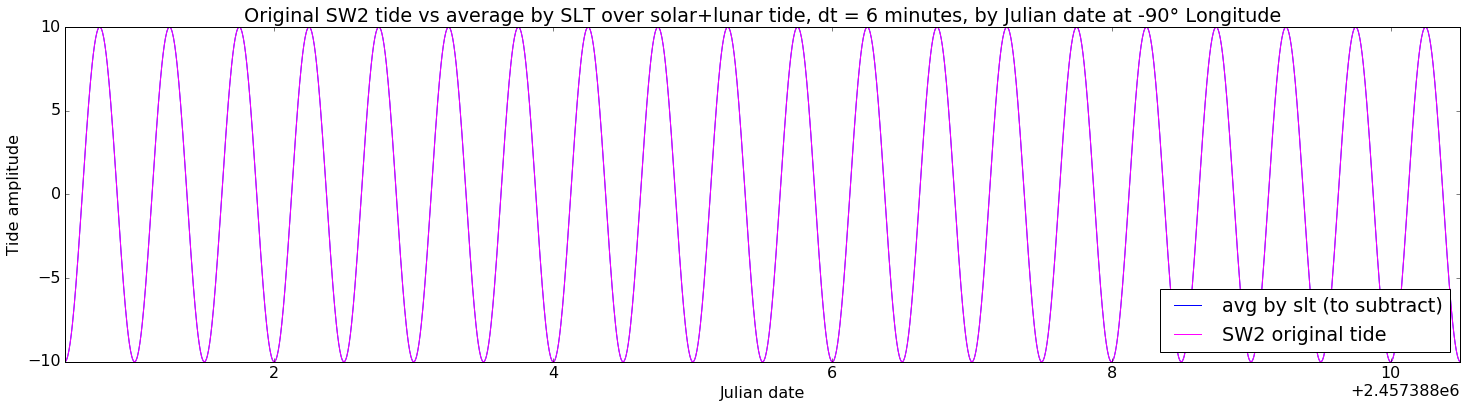

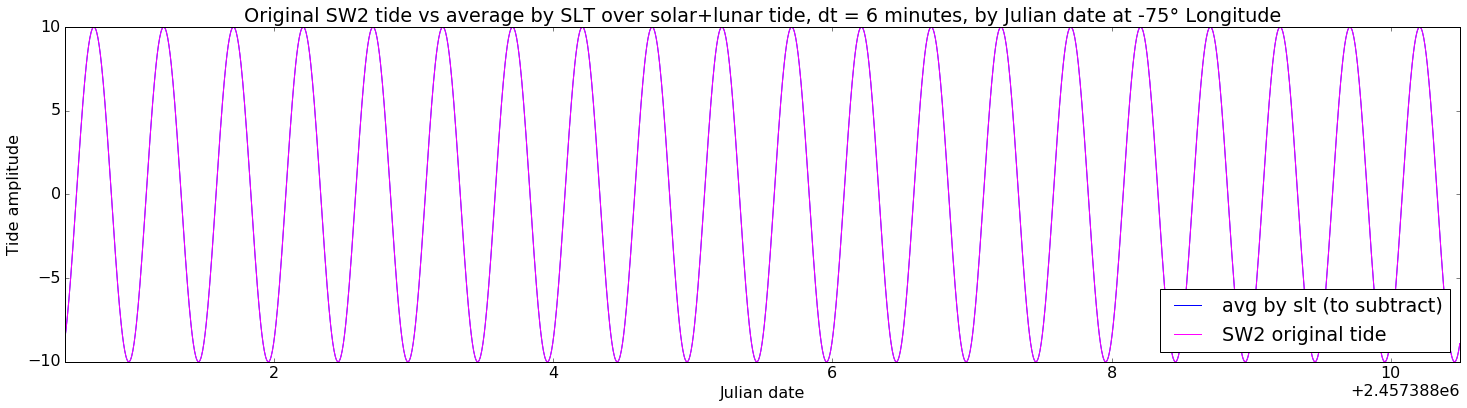

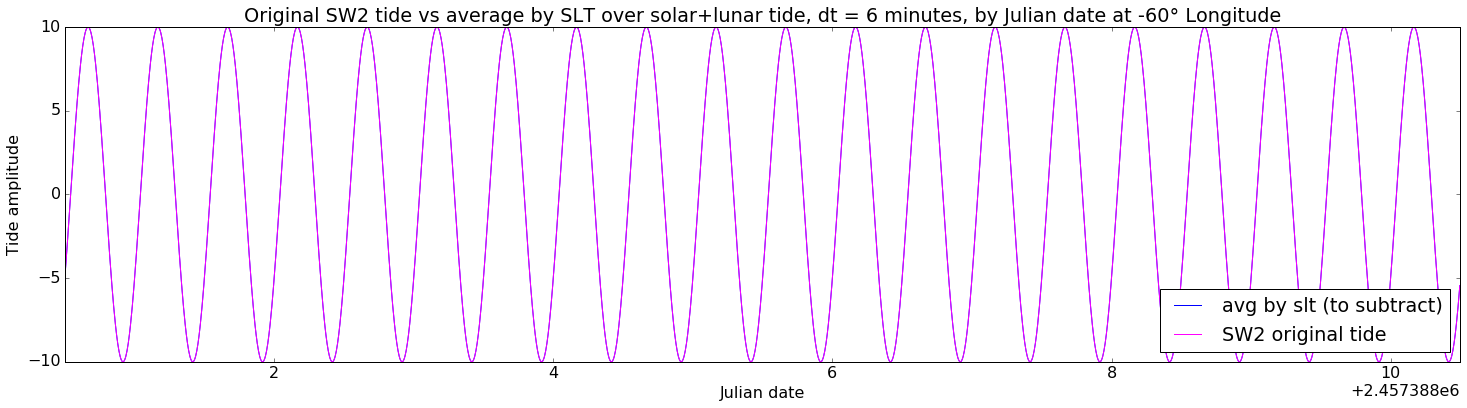

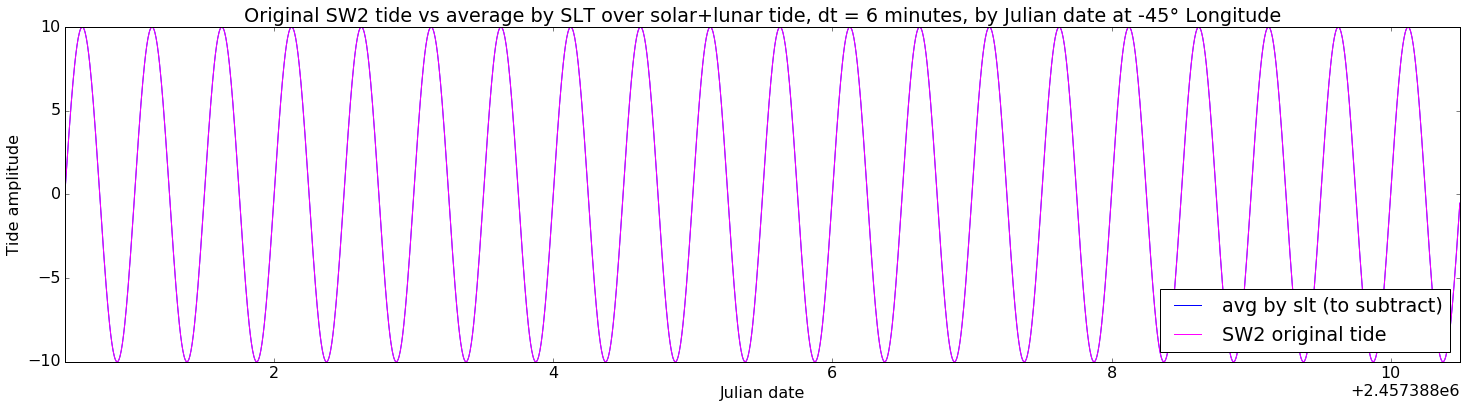

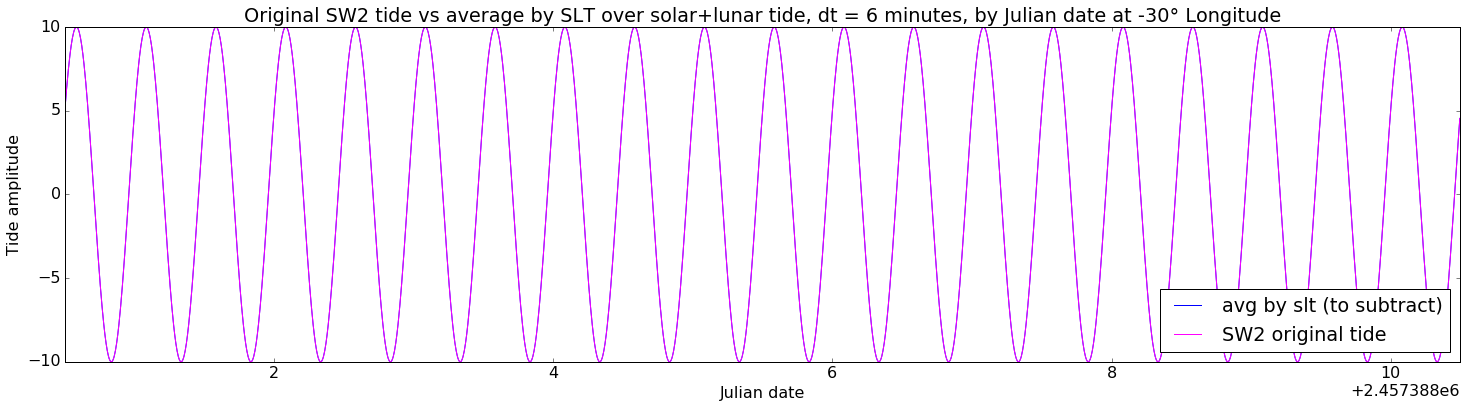

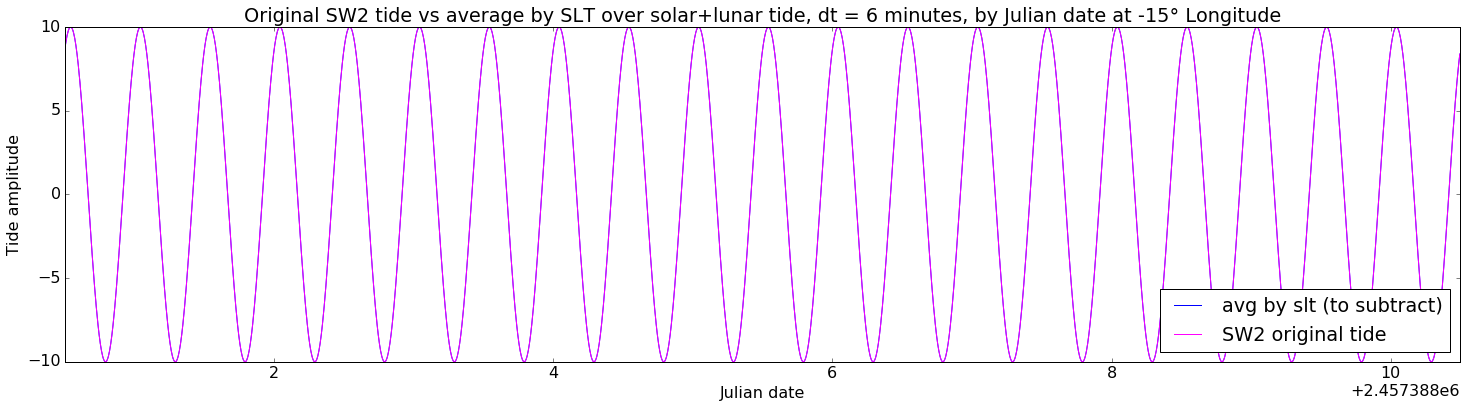

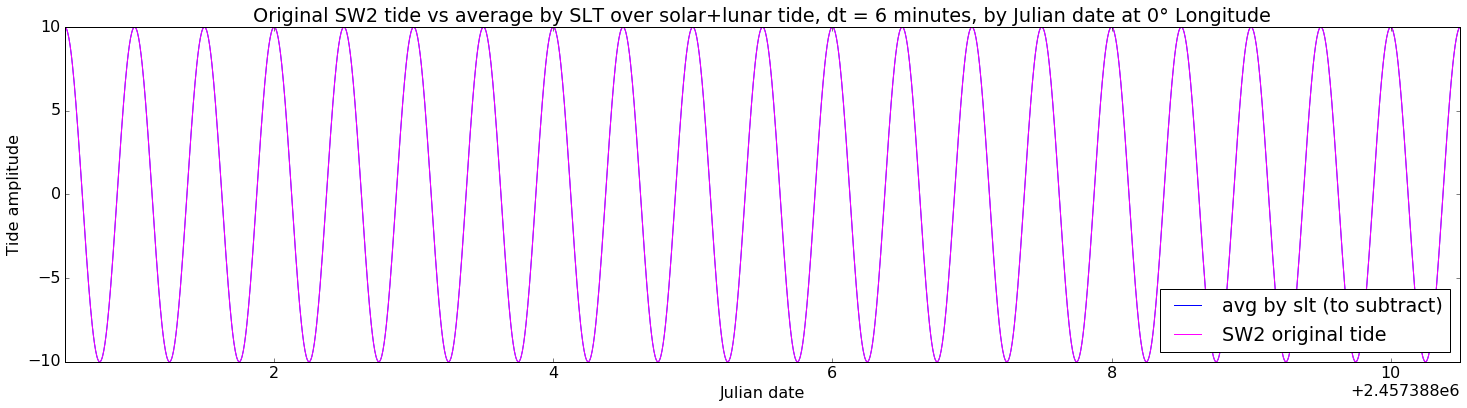

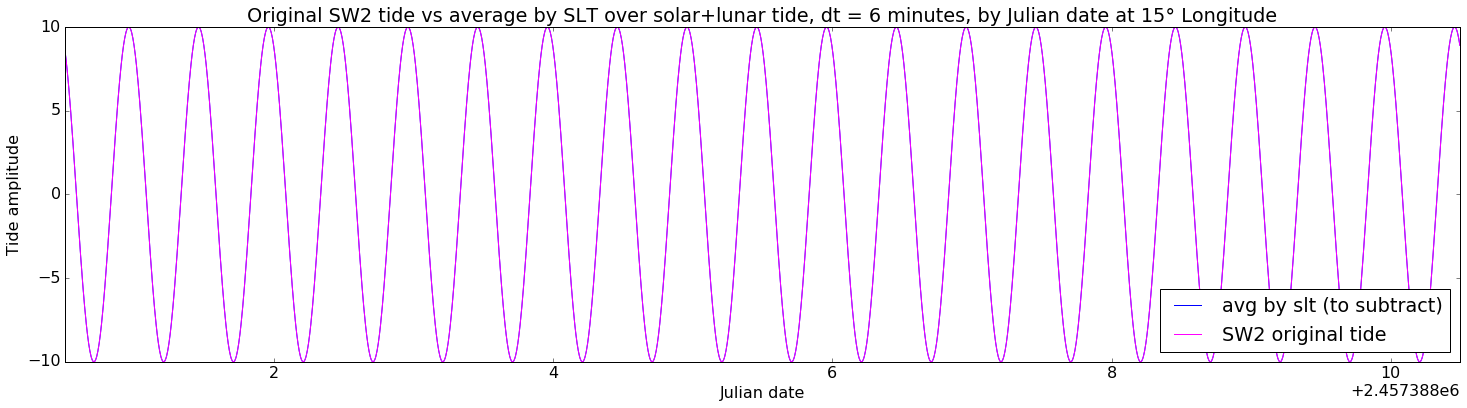

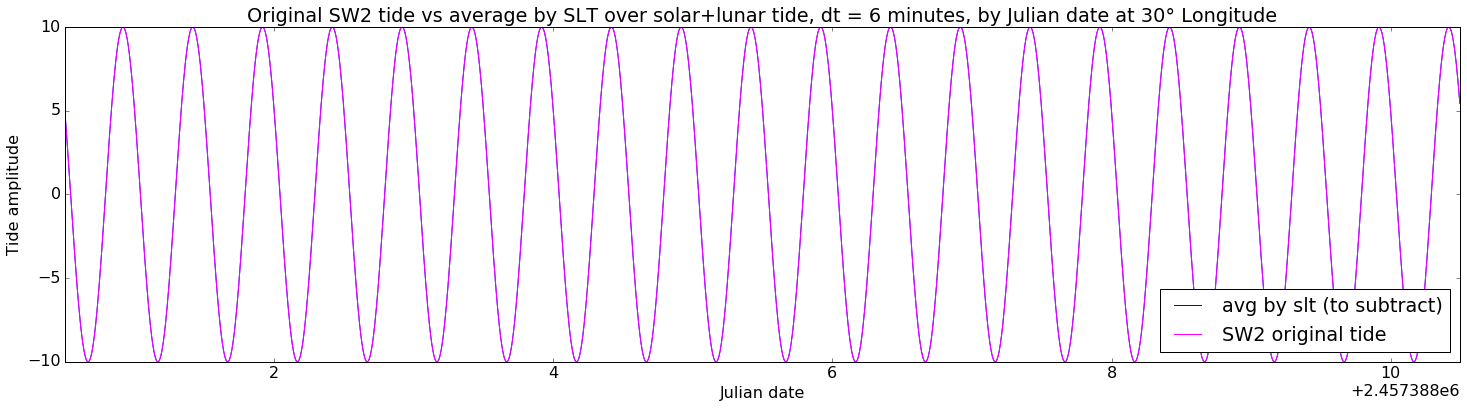

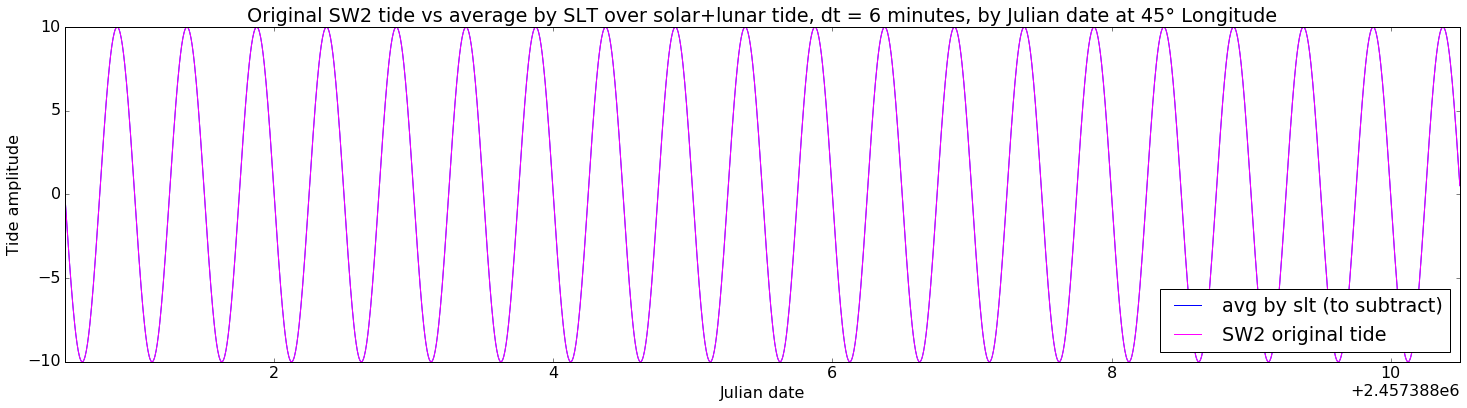

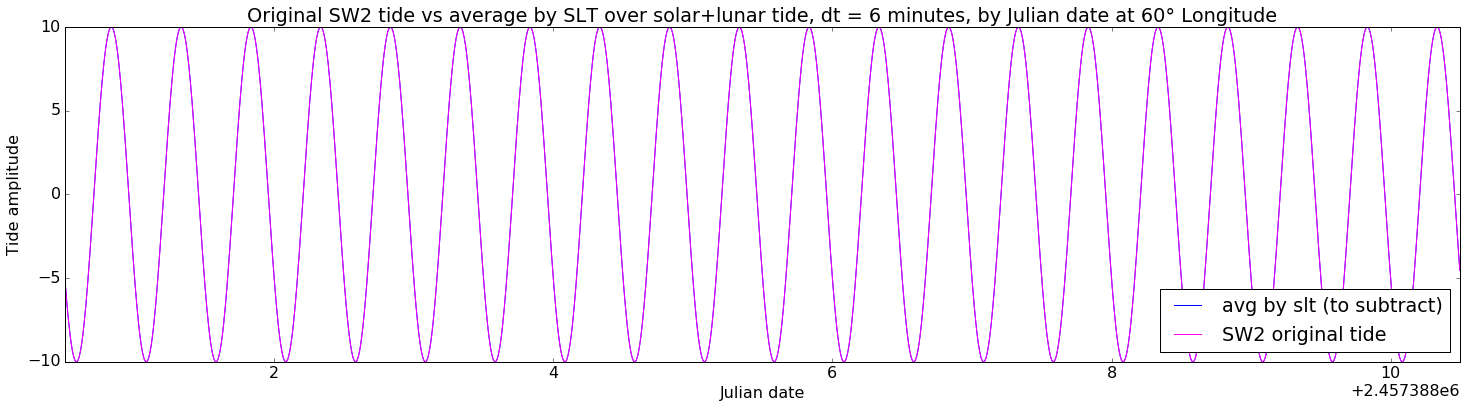

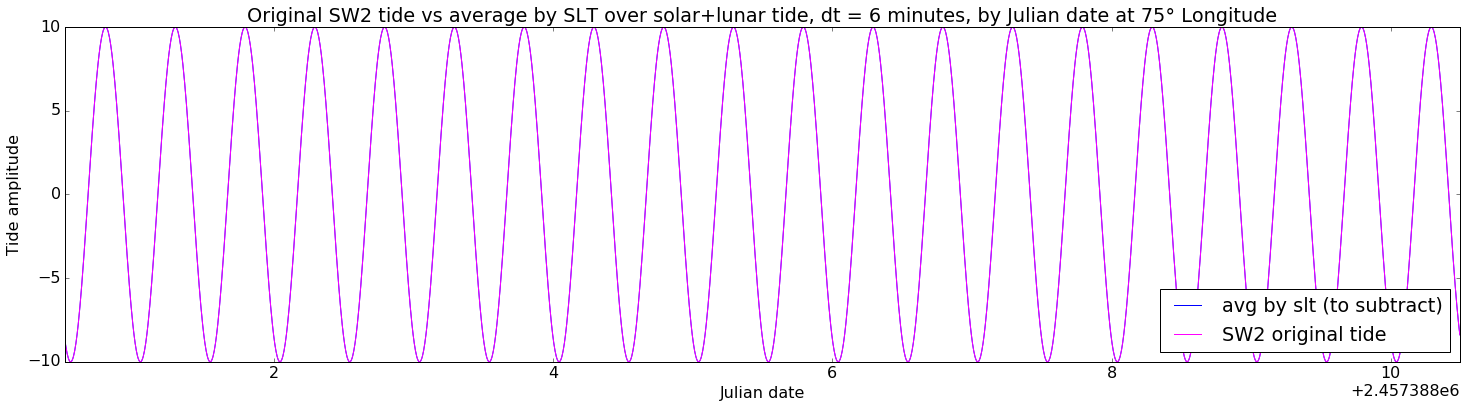

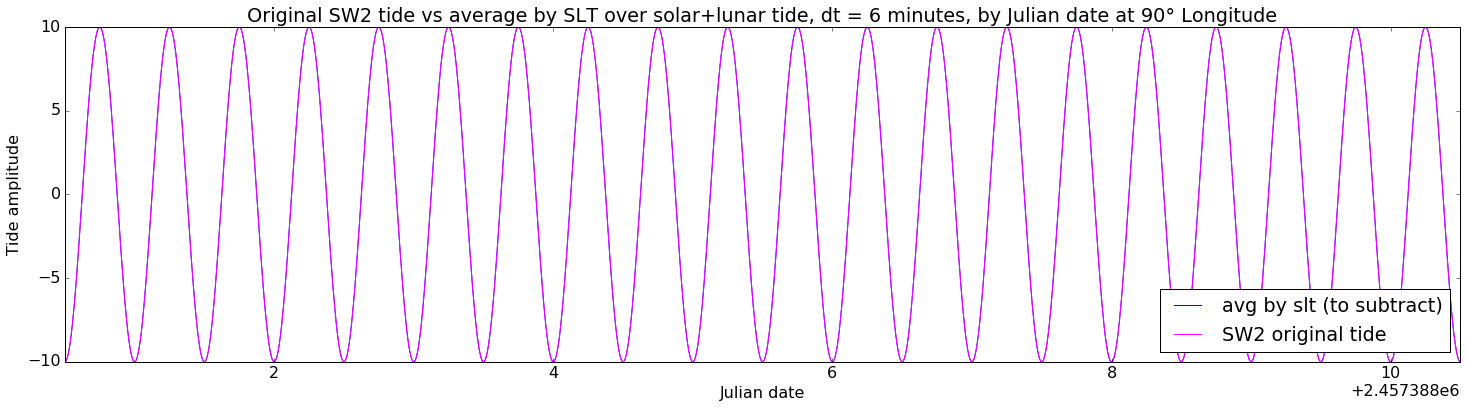

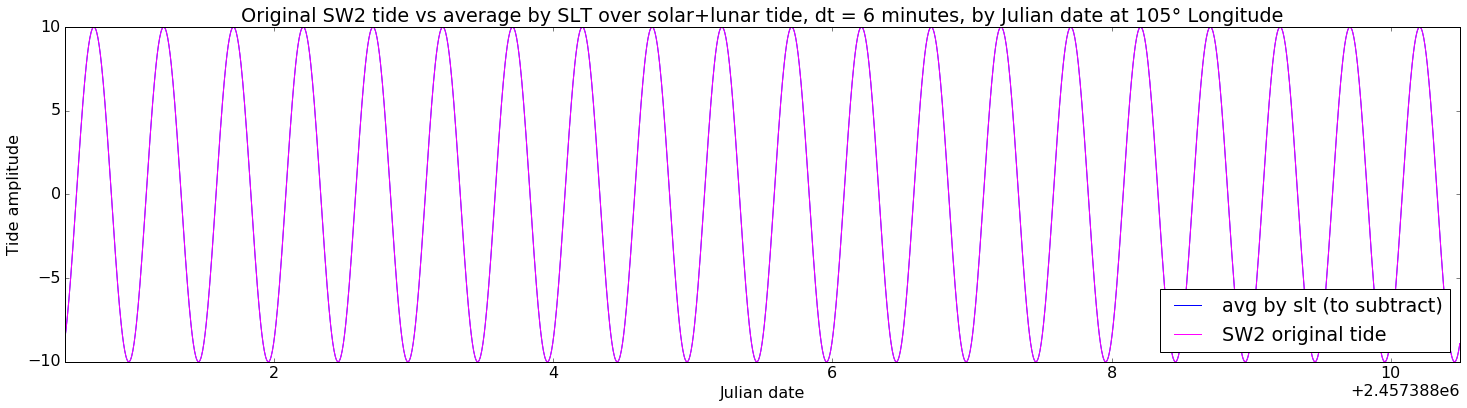

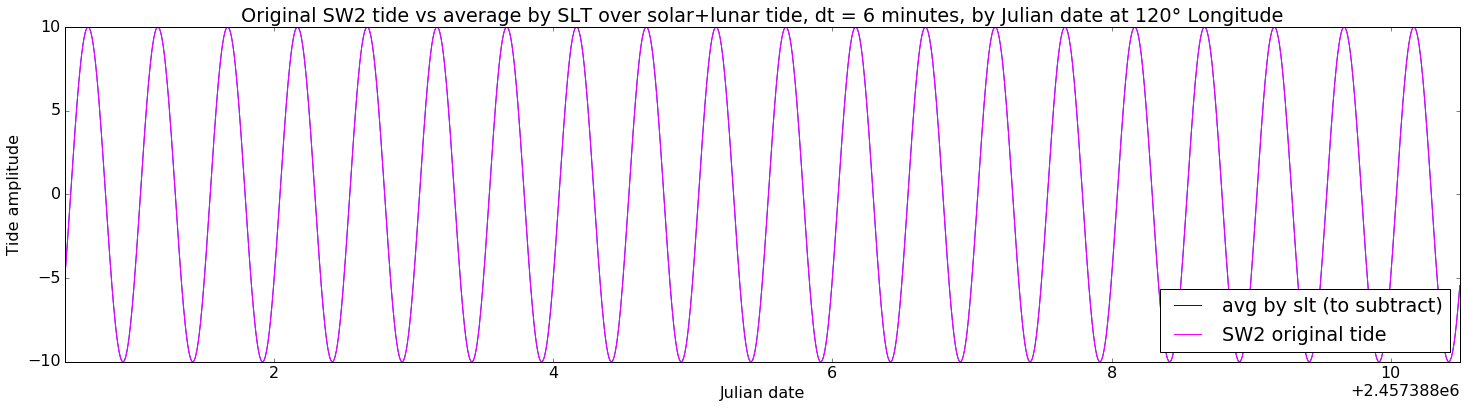

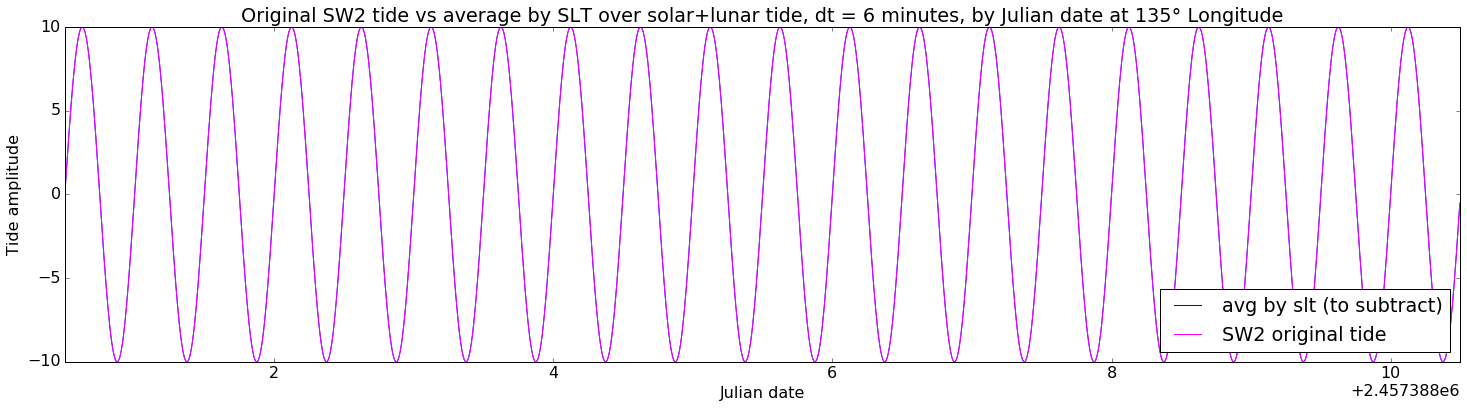

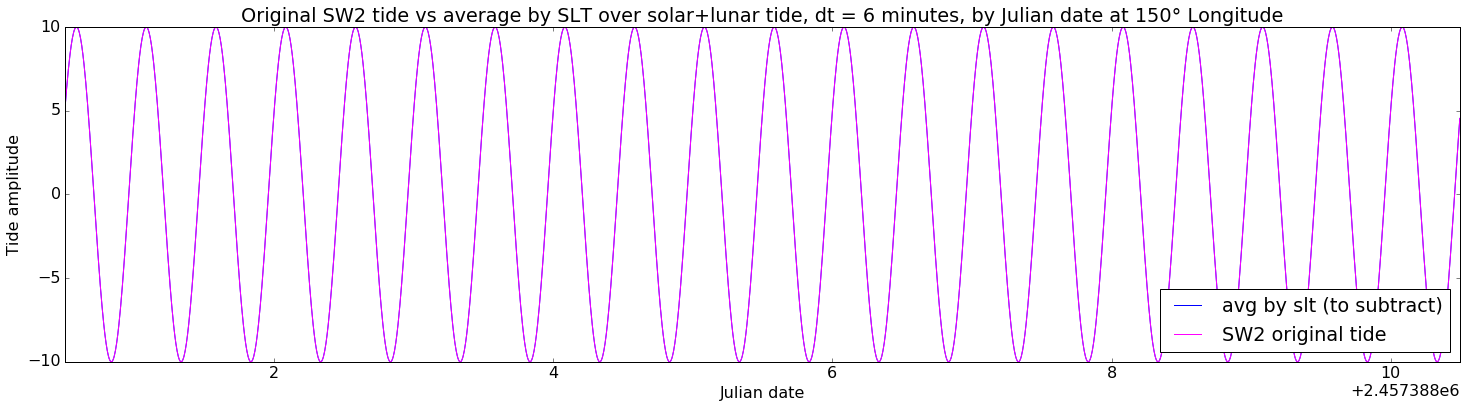

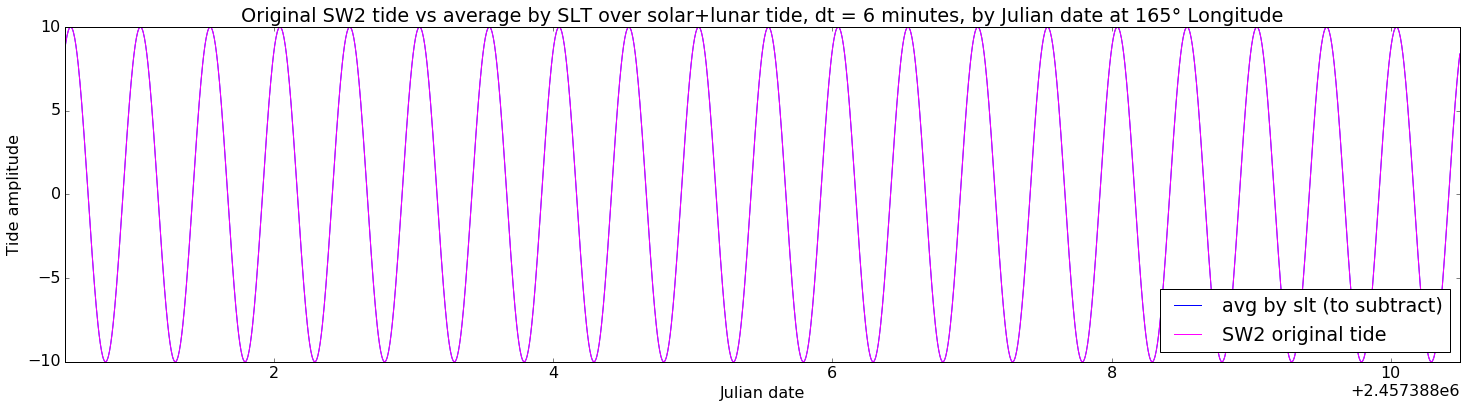

In [2]:
for long in range(-180, 180, 15):
    dt = 0.1
    #============================================================================#
    # Generate SW2 data
    # Background = 0, Constant amplitude and phase
    #============================================================================#
    data1S = generate_tides('2016-01-01', '2016-01-10', amps=[0,10,10], phase='C',
                            dt=dt, nRange=[2], sRange=[2], filename='SW2_scenario1.txt', 
                            component='solar')


    # Bin by solar local time
    means1S = bin_by_solar(data1S, '1T')

    # Subtract the averages according to solar local time
    subtractedValues, nosol1S = remove_solar(data1S, means1S)

    # Compare input total to solar averages
    plot_vs_date(subtractedValues, long, 'Original SW2 tide vs average by SLT over solar+lunar tide, '
                'dt = {} minutes,'.format(int(dt*60)), data2=data1S, 
                c=['blue', 'magenta'], lb=['avg by slt (to subtract)','SW2 original tide'], 
                mode='show')


    print('=============================================================================================')

No problems there either.

# 5 July 2016

So, what happened last time and what is there to do?

_Last time_
- Installed PyCharm - trying to learn that to make running code easier

_To Do_
- Go through Ruth's no_gaps script and see if I can glean anythng useful from it
- **Figure out why the spikes are there.**

## Some PyCharm notes

**File Colors**
blue = file is tracked in git and has been changed since last git commit
red = file is untracked in git
white = file is tracked in git and has not changed since last commit

##  Examining the screwy plot numerically

/home/emc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:168: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/emc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:407: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


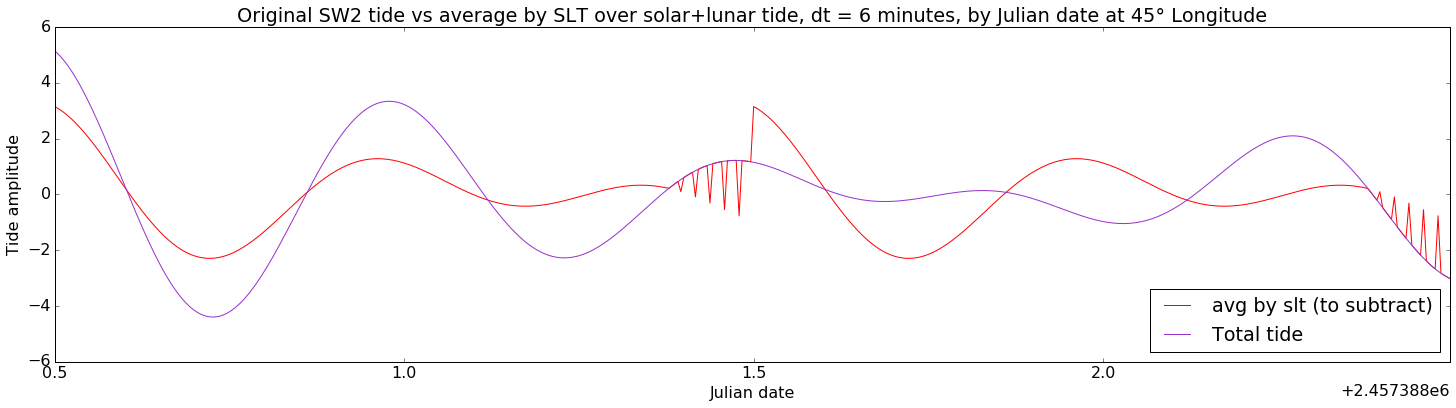

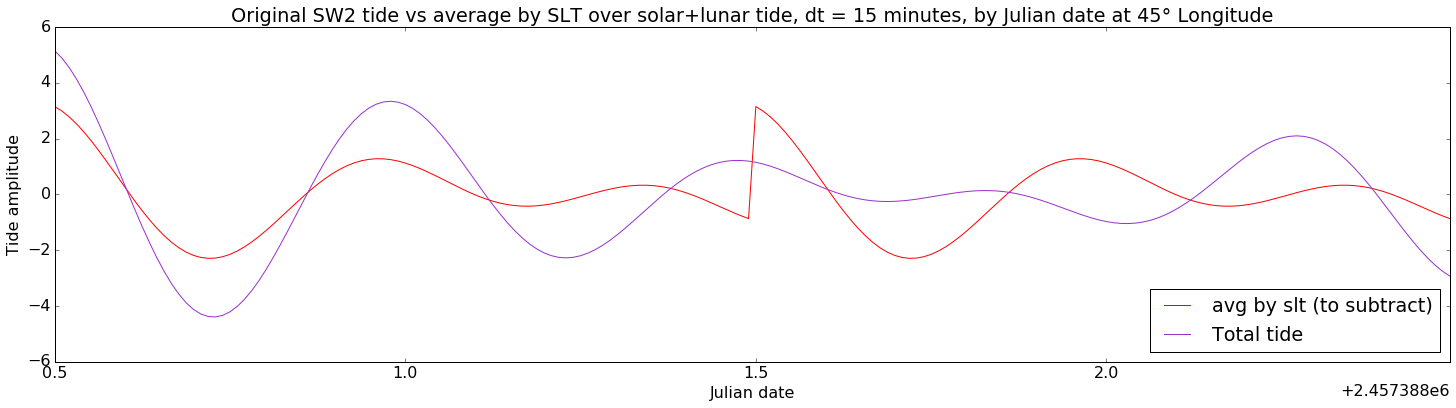

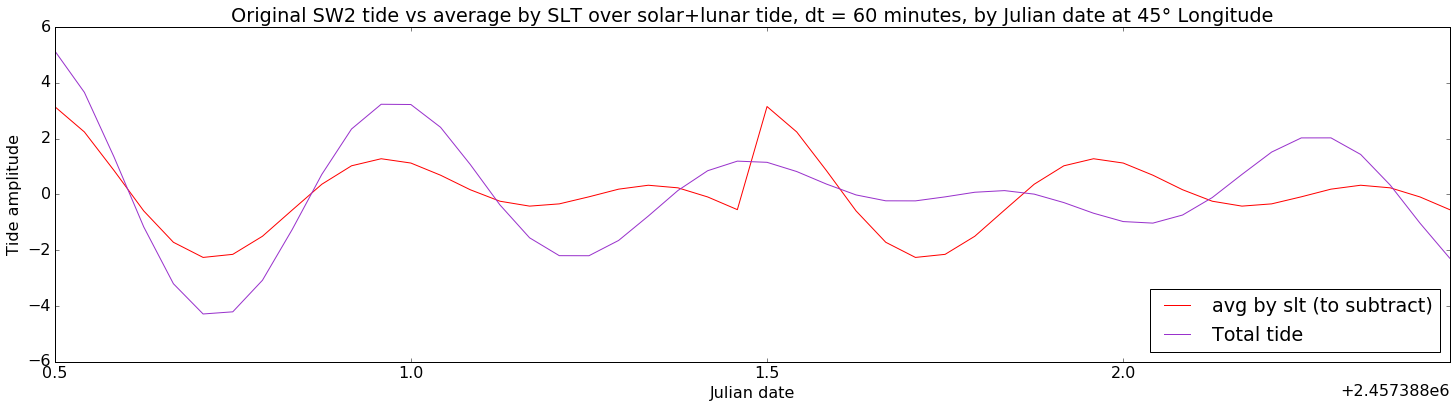

In [5]:
for dt in [0.1, 0.25, 1]:

    #============================================================================#
    # Generate total data
    # Background = 0, Constant amplitude and phase
    #============================================================================#
    data1T = generate_tides('2016-01-01', '2016-01-02', amps=[0,10,10], phase='C',
                            dt=dt, nRange=[2], sRange=[2], filename='TT_scenario1.txt', 
                            component='s+l')

    # Bin by solar local time
    means1T = bin_by_solar(data1T, '1T')

    # Subtract the averages according to solar local time
    subtractedValues, nosol1T = remove_solar(data1T, means1T)

    # Compare input total to solar averages
    plot_vs_date(subtractedValues, 45, 'Original SW2 tide vs average by SLT over solar+lunar tide, '
                'dt = {} minutes,'.format(int(dt*60)), data2=data1T, 
                c=['red', 'darkorchid'], lb=['avg by slt (to subtract)','Total tide'], 
                mode='show')

    
    print('=============================================================================================')

10:33 - with Astrid

A suggestion of something to try: add in the mgirating diurnal tide (period = 24, wn = 1); add it in to the total tides; then look at the averages again.

Also: Use ONLY lunar tide, then do solar binning; amplitude and phase may slightly shift but we do not expect the sudden jump. 

If it is still in there, look right at the problem point.

11:51 am

After 3 hours of fighting with Matplotlib I have a plot of everything all together so I can test things.

<img src="pics/Solar averages vs total solar+lunar tide by Julian date at -120° Longitude.png" />

Now I'll do what Astrid said above. Using the migrating diurnal tide also, we will have TWO components with attributes:

Solar semidiurnal: n=2, s=2
Solar diurnal: n=1, s=1

**The code is not set up to do it this way! It matches every n with every s! This needs to be changed!**

I added a quick "if n==s" to the part where it sums to control that.

## Semidiurnal and diurnal tides

No problem here.

<img src="pics/Solar averages vs solar semidiurnal+diurnal tide by Julian date at -120° Longitude.png" />

(Ignore the legend. I forgot to change it.)

## Use only lunar semidiurnal tide

Aha! This has the problem.

<img src="pics/Lunar semidiurnal tide and average over SLT, by Julian date at -120° Longitude.png" />

2:27 pm
    
OK, after mucking around for a bit I've got a file of the averages for the data shown above. Let's extract some info and examine it.  

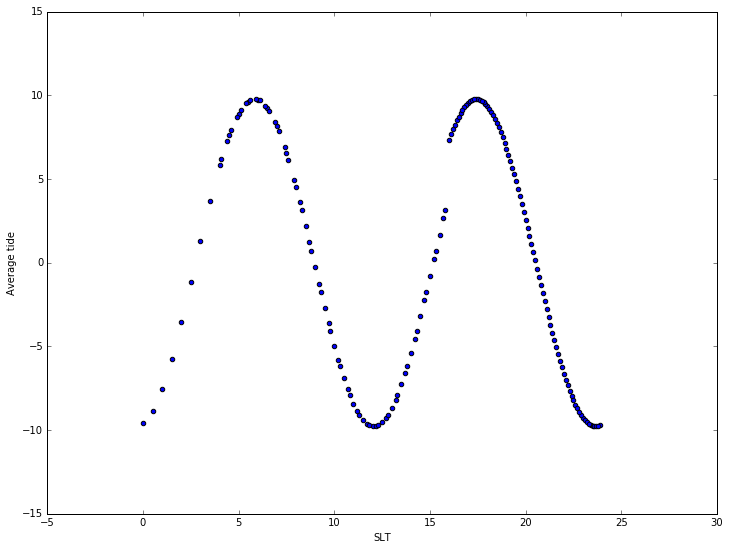

In [2]:
# Read in the recorded average data
averages = np.loadtxt('means1L0.1.txt')
avgs120 = averages[np.where(averages[:,1]==-120)]

# Plot the average versus the SLT value
plt.figure(figsize=(12,9))
plt.scatter(avgs120[:,0], avgs120[:,2])
plt.xlabel('SLT')
plt.ylabel('Average tide')
plt.show()

Huh... it looks like something really weird is going on at 16 or so. Also, it seems weird that some parts of the line are "denser"... like some values may be missing averages! Let's print the numbers again and look.

In [3]:
print(avgs120[np.argsort(avgs120[:,0])])

[[   0.     -120.       -9.6056]
 [   0.5    -120.       -8.8473]
 [   1.     -120.       -7.5259]
 [   1.5    -120.       -5.7256]
 [   2.     -120.       -3.561 ]
 [   2.5    -120.       -1.1698]
 [   3.     -120.        1.2959]
 [   3.5    -120.        3.6791]
 [   4.     -120.        5.8282]
 [   4.1    -120.        6.2175]
 [   4.4    -120.        7.2862]
 [   4.5    -120.        7.6064]
 [   4.6    -120.        7.907 ]
 [   4.9    -120.        8.6849]
 [   5.     -120.        8.9005]
 [   5.1    -120.        9.0934]
 [   5.4    -120.        9.5309]
 [   5.5    -120.        9.6283]
 [   5.6    -120.        9.7012]
 [   5.9    -120.        9.7703]
 [   6.     -120.        9.7434]
 [   6.1    -120.        9.6916]
 [   6.4    -120.        9.3881]
 [   6.5    -120.        9.2385]
 [   6.6    -120.        9.0652]
 [   6.9    -120.        8.4084]
 [   7.     -120.        8.1456]
 [   7.1    -120.        7.862 ]
 [   7.4    -120.        6.8937]
 [   7.5    -120.        6.5345]
 [   7.6  

Looks definitely like certain values of the SLT are not being used. Also, Dr. Maute suggested looking at the number of values used to compute each average. I have edited the code to produce a file tracking this. The numbers used look alright (it's 2 numbers for each calculation, which makes sense since this is a simulation over 2 days). But some values are still missing. For instance, the SLT of 0.1 only appears *once* at longitude 0:

In [4]:
# Read in the values used
load = np.loadtxt('valsused0.1.txt')
vu = load[np.where(load[:,0]==0.1000)]
print('Entries for when solar local time is 0.1:')
print(vu)

print()
print('Entries for when solar local time is 15.4:')
vu = load[np.where(load[:,0]==15.4000)]
print(vu)

Entries for when solar local time is 0.1:
[[ 0.1  0.   2. ]]

Entries for when solar local time is 15.4:
[[  15.4 -180.     2. ]
 [  15.4 -165.     2. ]
 [  15.4 -135.     2. ]
 [  15.4    0.     2. ]
 [  15.4   15.     2. ]
 [  15.4   30.     2. ]
 [  15.4   45.     2. ]
 [  15.4   60.     2. ]
 [  15.4   90.     2. ]
 [  15.4  120.     2. ]
 [  15.4  135.     2. ]
 [  15.4  165.     2. ]]


Cross check with the averages data:

In [5]:
a = averages[np.where(averages[:,0]==0.1000)]
print('Entries for when solar local time is 0.1:')
print(a)

print()
print('Entries for when solar local time is 15.4:')
b = averages[np.where(averages[:,0]==15.4000)]
print(b)

Entries for when solar local time is 0.1:
[[ 0.1     0.     -9.0823]]

Entries for when solar local time is 15.4:
[[  15.4    -180.        4.489 ]
 [  15.4    -165.        4.6423]
 [  15.4    -135.        4.9443]
 [  15.4       0.        2.5543]
 [  15.4      15.        2.7212]
 [  15.4      30.        2.8872]
 [  15.4      45.        3.0523]
 [  15.4      60.        3.2165]
 [  15.4      90.        3.5417]
 [  15.4     120.        3.8625]
 [  15.4     135.        4.0211]
 [  15.4     165.        4.3344]]


Check to make sure it's not some weird thing with == not finding everything:

In [6]:
# Read in the recorded average data
np.set_printoptions(threshold=np.nan)
print(averages[np.argsort(averages[:,0])][:20])
print('...')

[[   0.     -180.       -9.7097]
 [   0.     -165.       -9.6882]
 [   0.     -135.       -9.6362]
 [   0.     -120.       -9.6056]
 [   0.      -90.       -9.5354]
 [   0.      -60.       -9.4533]
 [   0.      -45.       -9.4077]
 [   0.      -30.       -9.3592]
 [   0.      -15.       -9.3078]
 [   0.        0.       -9.2534]
 [   0.1       0.       -9.0823]
 [   0.2       0.       -8.888 ]
 [   0.4       0.       -8.4318]
 [   0.5     165.       -9.1804]
 [   0.5     150.       -9.2385]
 [   0.5     135.       -9.2936]
 [   0.5     120.       -9.3458]
 [   0.5     105.       -9.3951]
 [   0.5      90.       -9.4415]
 [   0.5      75.       -9.4848]]
...


Okay. Yeah. Something is definitely up. A quick look at the file of original tidal data generated shows that it's being generated wrong. All I have to do is Ctrl+F on the values '15.4000 ' and '17.4000 ' (the space added to be absolutely sure I get the right column):

<img src="pics/154.png" />
<img src="pics/174.png" />

Time to investigate the original script... since I mostly copied Dr. Lieberman's, I suspect this isn't 100% my bad.

4:16 pm

I tried using the debugger to step through the tide generation code, but it proved a bit tedious and it was hard to see the forest for the trees: that is, the problem is that some values are not generated, but it's hard to see that when debugging.

I think a better tactic is to use Rubber Duck Debugging. I'm going to do it by just re-writing the explanation of the code.

4:47 pm

I've been doing RDD but i'm not sure its actually useful. the problem should be with the tide generation sinc the solar was fine.

Does it get better if I use a longer time window for lunar-only? Let's try..

<img src="pics/Lunar semidiurnal tide and average over SLT, 30 day window at -120° Longitude.png" />
Answer: No

5:14 pm
    
I got it to look better by doing this for the equation:

    tide += A_L * cos((2*pi*n/24.84)*fHr + s*l - p)
    
instead of this:

    tide += A_L * cos((2*pi*n/24)*(fHr - nuHr) + s*l - p)

Here's what it looks like.


<img src="pics/SW2 and average over SLT, by date, with eqn mod, at -120° Longitude.png" />



But why the jig at date = 2457389.5 and not anywhere else? let's extract the relevant information to have a look at what's going on....

Okay here's the relevant data for -120 long only, at the jig spot. It turns out the jig is right when the day rolls over. That jig is probably due to the use of UT in the equation.

<img src="pics/jigspot.png" />

Note how the tides are decreasing by 0.5 each time except when they reach the point when they roll over to the new day--then they decrease by 5!

If this equation is good, then we move forward. The only challenge in that case would be figuring out why the jig at the day turn-over.

To do tomorrow: 
- Look explicitly at which values are used to calculate the averages in the case of dt=0.1, with jaggedness 
- Discuss with Astrid

Things to discuss with Astrid:
- Same number of values used to calculate averages each time
- Could not find explanation for missing values
- After switching the equation, the missing values problem and the jaggedness went away but introduced a jig in even the original data where the day switches over
- Jig due to day turn over in both cases (use of ut only and ut-moon phase)
- Figure out why the jig/jaggedness
- ascertain correct equation 


Real quick I wanna generate a similar file as to above (120 stuff only) for the original equation I was using. Okay, done--but it doesn't show anything interesting like in the screenshot above, since when using the original equation, there is no jig. This makes me think it's correct.



# 6 July 2016

Let's start by showing proof that the missing values problem went away when I used the new equation, since I didn't actually do that.

In [9]:
avgs_UT_eq = np.loadtxt('means1L_dt=0.1_UT_eq.txt')

a = avgs_UT_eq[np.where(avgs_UT_eq[:,0]==0.1000)]
print('Entries for when solar local time is 0.1:')
print(a)

print()
print('Entries for when solar local time is 15.4:')
b = avgs_UT_eq[np.where(avgs_UT_eq[:,0]==15.4000)]
print(b)

print()
print('Entries for when solar local time is 3.6:')
c = avgs_UT_eq[np.where(avgs_UT_eq[:,0]==3.6000)]
print(c)

Entries for when solar local time is 0.1:
[[ 0.1     0.      9.9872]]

Entries for when solar local time is 15.4:
[[  15.4    -180.       -1.4868]
 [  15.4    -165.       -1.6617]
 [  15.4    -135.       -2.0098]
 [  15.4       0.        0.6319]
 [  15.4      15.        0.4551]
 [  15.4      30.        0.2782]
 [  15.4      45.        0.1012]
 [  15.4      60.       -0.0759]
 [  15.4      90.       -0.4299]
 [  15.4     120.       -0.7833]
 [  15.4     135.       -0.9597]
 [  15.4     165.       -1.3115]]

Entries for when solar local time is 3.6:
[[  3.6      0.      -2.4781]
 [  3.6     15.      -2.6492]
 [  3.6     30.      -2.8195]
 [  3.6     45.      -2.989 ]]


Okay, so actually there are still "missing values." But since the code that produced these tables also produces the cleaner plot where the original data and subtractions match, maybe the missing values aren't actually the problem; it's something else caused by the use of the equation where we have the term (UT - moon phase).

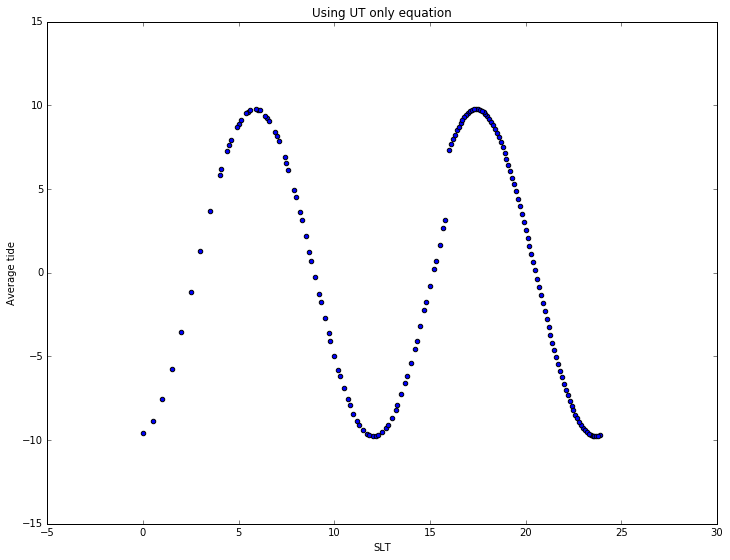

In [10]:
# Read in the recorded average data
avgs120_UT = avgs_UT_eq[np.where(avgs_UT_eq[:,1]==-120)]

# Plot the average versus the SLT value
plt.figure(figsize=(12,9))
plt.scatter(avgs120_UT[:,0], avgs120[:,2])
plt.xlabel('SLT')
plt.ylabel('Average tide')
plt.title('Using UT only equation')
plt.show()

Same plot as before as to the "missing values."

## A new question

I have thought of a new question: Just HOW are the subtracted values being plotted? Maybe this is just a stupid plotting error. The averages are by solar local time. I'm pretty sure I collected data of the averages in the same format as the original tides (i.e. by SLT and longitude) but I should check.

Yeah, no, this is fine. I'm 99% sure it's fine. Unless something went weird with copying arrays but that's not likely since I can remove the problem just by changing the equation.

## Exact values used to calculate average

First, here is the raw data for just -120 longitude when generated using the original equation (as opposed to the UT one, shown in the screenshot from yesterday):

<img src="pics/rawdata_long-120_origeq.png" />

Then, I changed the bin_by_solar function to contain the following code that outputs information when the longitude is -120 and the solar time is between 15.4 and 16.2:

    # ITERATE OVER SOLAR LOCAL TIMES & LONGITUDES ----------------------------
    for val in unique_slt:
        for lon in range(-180, 180, 15):
            sltSlice = data[np.where(data[:,0] == val)]
            sltSlice2 = sltSlice[np.where(sltSlice[:,2]==lon)]
            if sltSlice2.size != 0:
                if lon==-120 and 15.4<=val<=16.2:
                    print(sltSlice2)
                vals_to_avg = sltSlice2[:,6]
                values_used.append([val, lon, len(vals_to_avg)])
                means.append([val, lon, np.mean(vals_to_avg)])
                
It SHOULD output info for all those values since they clearly exist as shown in the screenshot, but instead I only get:

[[  15.5000  21.7370210e+01  -120.0000   2457389.4800    23.5000   1.77629790e+01   3.76396141]
 [  15.5000   2.0.9243043e+01  -120.0000   2.45739048    23.5000   1.85756957e+01  -0.396237794]]

 [[  15.7000  21.9302483e+01  -120.0000   2457389.4900     23.7000   1.77697517e+01   4.6804]
  [  15.7000  21.1175317e+01  -120.0000   2457390.4900   23.7000   1.85824683e+01   0.6150]]
 
[[  15.8000  22.0268620e+01  -120.0000   2457389.4900     23.8000   1.77731380e+01   5.1213]
 [  15.8000  21.2141454e+01  -120.0000   2457390.4900   23.8000   1.85858546e+01   1.1189]]

[[  16.0000  23.0328060e+01  -120.0000   2457388.50    0.0000   1.69671940e+01   8.7448]
 [  16.0000  22.2200894e+01  -120.0000   2457389.50    0.0000   1.77799106e+01   5.9626]]
 
[[  16.1000  23.1294197e+01  -120.0000   2457388.50    0.1000   1.69705803e+01   8.9789]
 [  16.1000  22.167031e+01  -120.0000   2457389.50    0.1000   1.77832969e+01   6.3609]]
 
[[  16.2000  23.2260334e+01  -120.0000   2457388.51    0.2000   1.69739666e+01   9.1900]
 [  16.2000  22.4133167e+01  -120.0000   2457389.51    0.2000   1.77866833e+01   6.7429]]

 Averages in order (rough):

1.9<br />
2.6<br />
3.1<br />
7.5<br />
7.6<br />
7.9<br />
 
 
 
Where are 15.4, 15.9 and 15.6???

11:01 am

Just checked that the code does indeed generate pairs correctly when doing the solar binning and averaging:

    15.9 and -180
    15.9 and -165
    15.9 and -150
    15.9 and -135
    15.9 and -120
    15.9 and -105
    15.9 and -90
    15.9 and -75
    15.9 and -60
    15.9 and -45
    15.9 and -30
    15.9 and -15
    15.9 and 0
    15.9 and 15
    15.9 and 30
    15.9 and 45
    15.9 and 60
    15.9 and 75
    15.9 and 90
    15.9 and 105
    15.9 and 120
    15.9 and 135
    15.9 and 150
    15.9 and 165
 
Looks like the program just thinks there is no data for those two values...

    /home/emc/anaconda3/bin/python "/home/emc/Desktop/Link to LASP/Lunar Tides Project/calling script.py"
    15.9 and -120 has the data: 
    []

    Process finished with exit code 0
    
    
But that data *definitely exists*. Here is a screenshot from the very file that is written out by the data-generator function:

<img src="pics/data_exists_for_15pt9.png" />

That seems to mean that the only possibility is that the array being fed into bin_by_solar is wrong and different from the file, which appears to be right.

Aha!

By trying this in the main calling script

    print(data1L[np.where((data1L[:,0]==15.9000) & (data1L[:,2]==-120.0000))])
    
I got a return of nothing. Therefore it must be a STUPID ROUNDING ERROR. One I have even seen before. Ugh.<br />

<b><font size=40>STUPID ROUNDING ERROR</font></b>

3:19 pm

Fixed the stupid rounding error and also met with Astrid. We determined that the problem with the jig in the equation where the plots otherwise matched was that we were re-starting the calculation at 24 hours--which is controlled by the UT value (fHr in my code)--but that's only valid for the solar cycle. In order to do it for the lunar, we need to just count UT from start without looping back at 24 hours. Duh!

3:51 pm
    
SO a challenge with switching the equation is that I have to change all the loops. It's nice because I can just loop through time steps (say, 30 minutes for 96 hours) but that means I have to change the way I calcuate the new date and convert back and forth between Julian because I don't think you can calculate "what is 30 minutes in Julian time."

Maybe that's why Ruth did it in normal time first. ugh.

4:00 pm
  
After some messing around with a NASA calculator I found online (For ease of use) it seems that one hour in Julian time is pretty consistently 0.0416667 days in length. The only time this gets mucked up is the midnight hour on 15 October 1582 because that's when the screwed with the calendar. So I'll just use that number to add on the time steps (and various multiples as needed) and just note that the sim doesn't work for that date in 1582.

Oh, crap, it doesn't work on leapyears either. 

Maybe I'll just make a note of it.

4:41

Not done fixing function yet. Stupid index error.


# 7 July 2016

Debugging.

In [22]:
dt = 0.5
n_days = 2
n_hours = (24 * n_days)
print('Hours: {}'.format(n_hours))
timesteps = np.arange(0, n_hours, dt)
print(timesteps)
print('Timestep number: {}'.format(len(timesteps)))

numLongs = 360 / 15
print('Long num: {}'.format(numLongs))
rows = numLongs * n_hours
print(rows)
print(n_timesteps * numLongs)

Hours: 48
[  0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5
   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5
  12.   12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5
  18.   18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5
  24.   24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5
  30.   30.5  31.   31.5  32.   32.5  33.   33.5  34.   34.5  35.   35.5
  36.   36.5  37.   37.5  38.   38.5  39.   39.5  40.   40.5  41.   41.5
  42.   42.5  43.   43.5  44.   44.5  45.   45.5  46.   46.5  47.   47.5]
Timestep number: 96
Long num: 24.0
1152.0
1152.0


10:40 am

Well, the good news is that using a continuous UT count in hours makes the two equations behave the same way, but there is still a jig at the new day. And spikes. 

<img src="pics/Lunar semidiurnal tide and average over SLT, (t-nu) by Julian date at -120° Longitude.png" />

<img src="pics/Lunar semidiurnal tide and average over SLT, (t only) by Julian date at -120° Longitude.png" />

11:08 am

I checked the moon phase calculation function. I'm pretty sure it's correct.

**why is there still a jig**

I am starting to suspect that if I solve the jig problem, the spikes will go away... but maybe not... since the spikes are only prsent for dt = 0.1


Something interesting... the spikes show up for dt = 0.2 hours and dt = 0.3 hours but not dt = 0.25 hours.

<img src="pics/M2 and average over SLT, varying dt,  by Julian date at -120° Longitude.png" />

Spikes everywhere for dt = 0.4, 0.6, 0.8:

<img src="pics/(2)M2 and average over SLT, varying dt,  by Julian date at -120° Longitude.png" />

A correction...

Using the equation

    tide += A_L * cos((W*n)*(t-nuHr) + s*L - p)
    
Results in a jig that "leans backward"

Using the equation

    tide += A_L * cos((2*pi*n/24.84)*t + s*L - p)
    
Results in a jig that "leans forward"

and the waves are slightly different for each

Note that the solar tides have no problem being 100% accurate for any value of dt:

<img src="pics/SW2 and average over SLT,  by Julian date at -120° Longitude.png" />

Here it is with the total tide and averaging that... spikes still exist here because the lunar is in there and we've chosen bad dt:

<img src="pics/Tides and average over SLT, small dt, by Julian date at -120° Longitude.png" />

If we choose dt that doesn't produce spikes:

<img src="pics/Tides and average over SLT, by Julian date at -120° Longitude.png" />

this seems to reinforce the idea that the jigs may be the major source of problems. If they weren't there, we may have a more "consistent" average that didn't cause problems in the lunar amplitude and phase reconstruction.

1:29 pm

Just realized that the jig only exists still in the averaging process. So I know at least where to look.

2:19 pm
    
After meeting with Astrid, we have agreed that I should change the binning and see what happens.

In [7]:
a = np.asarray([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
b = np.column_stack((a[:,0], a[:,2]))
b

array([[ 1,  3],
       [ 4,  6],
       [ 7,  9],
       [10, 12]])

In [8]:
[0]*12

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [13]:
c=len(range(-180,180,15))
means = np.zeros([c*24, 3])
print(means)


[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 ..., 
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


In [18]:
data = np.asarray([[0.0000, 999, -180, 999, 999, 999, 5], [0.0000, 999, -165, 999, 999, 999, 4], 
                   [0.5000, 999, -180, 999, 999, 999, 6], [0.5000, 999, -165, 999, 999, 999, 6], 
                   [1, 999, -180, 999, 999, 999, 4], [1, 999, -165, 999, 999, 999, 3]])
data

array([[   0. ,  999. , -180. ,  999. ,  999. ,  999. ,    5. ],
       [   0. ,  999. , -165. ,  999. ,  999. ,  999. ,    4. ],
       [   0.5,  999. , -180. ,  999. ,  999. ,  999. ,    6. ],
       [   0.5,  999. , -165. ,  999. ,  999. ,  999. ,    6. ],
       [   1. ,  999. , -180. ,  999. ,  999. ,  999. ,    4. ],
       [   1. ,  999. , -165. ,  999. ,  999. ,  999. ,    3. ]])

In [19]:
col0 = np.around(data[:,0], decimals=4)
col1 = np.around(data[:, 2], decimals=4)
d = np.column_stack((col0, col1, data[:,6]))

print(d)

[[   0.  -180.     5. ]
 [   0.  -165.     4. ]
 [   0.5 -180.     6. ]
 [   0.5 -165.     6. ]
 [   1.  -180.     4. ]
 [   1.  -165.     3. ]]


In [24]:
longitudes = range(-180, 180, 15)
n_lon = len(longitudes)

# create an array to store the results
means = np.zeros([n_lon * 24, 3])
means[:,0] = list(range(0, 24)) * n_lon
print(means)
print(means.shape)

[[  0.   0.   0.]
 [  1.   0.   0.]
 [  2.   0.   0.]
 ..., 
 [ 21.   0.   0.]
 [ 22.   0.   0.]
 [ 23.   0.   0.]]
(576, 3)


In [27]:
s = 0
# ITERATE OVER SOLAR LOCAL TIMES & LONGITUDES ----------------------------
for lon in longitudes:
    slt_means = [0]*24
    data_by_lon = d[np.where(d[:, 1] == lon)]
    for row in data_by_lon:
        i = int(row[0]) # convert slt to an int
        slt_means[i] += row[2]

    means[s:s + 24, 1] = lon
    means[s:s + 24, 2] = slt_means
    s += 24
    print(means[s:s+24, 1])
    print(means[s:s+24, 2])

[-165. -165. -165. -165. -165. -165. -165. -165. -165. -165. -165. -165.
 -165. -165. -165. -165. -165. -165. -165. -165. -165. -165. -165. -165.]
[ 10.   3.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.]
[-150. -150. -150. -150. -150. -150. -150. -150. -150. -150. -150. -150.
 -150. -150. -150. -150. -150. -150. -150. -150. -150. -150. -150. -150.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
[-135. -135. -135. -135. -135. -135. -135. -135. -135. -135. -135. -135.
 -135. -135. -135. -135. -135. -135. -135. -135. -135. -135. -135. -135.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
[-120. -120. -120. -120. -120. -120. -120. -120. -120. -120. -120. -120.
 -120. -120. -120. -120. -120. -120. -120. -120. -120. -120. -120. -120.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  

3:30 pm 

Okay that was me testing the new binning... looking good. Now let's try with any old real data.


In [2]:
data = np.loadtxt('TT_revised.txt', skiprows=1)
print(data[:3])

[[      12.           19.0328     -180.      2457388.5           0.
        16.9672        1.4269]
 [      13.           20.0328     -165.      2457388.5           0.
        16.9672        3.8097]
 [      14.           21.0328     -150.      2457388.5           0.
        16.9672        5.1718]]


In [6]:
col0 = np.around(data[:,0], decimals=4)
col1 = np.around(data[:,2], decimals=4)
d = np.column_stack((col0, col1, data[:,6]))

longitudes = range(-180, 180, 15)
n_lon = len(longitudes)

# create an array to store the results
means = np.zeros([n_lon * 24, 3])
means[:,0] = list(range(0, 24)) * n_lon


s = 0
# ITERATE OVER SOLAR LOCAL TIMES & LONGITUDES ----------------------------
for lon in longitudes:
    slt_means = [0]*24
    data_by_lon = d[np.where(d[:, 1] == lon)]
    for row in data_by_lon:
        i = int(row[0]) # convert slt to an int
        if i == 24:
            i = 0
        slt_means[i] += row[2]

    means[s:s + 24, 1] = lon
    means[s:s + 24, 2] = slt_means
    s += 24

    
print(means)

[[   0.     -180.        4.5857]
 [   1.     -180.       -3.1768]
 [   2.     -180.       -9.2747]
 ..., 
 [  21.      165.        7.1669]
 [  22.      165.        9.1496]
 [  23.      165.       10.5462]]


3:43 pm
    
What to do when home
- Figure out if there wre SLT = 24 before and what to do with them
- Finish the binning function
- Try it on the data above
- Re-implement to the code and test

9 pm

In [9]:
top = np.asarray([10,15,20])
bot = np.asarray([5, 5, 5])

c= np.zeros([24])
c

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

9:24 pm

I finished the binning function, but it still has spikes. I'm still not entirely sure why, but I also noticed another problem in the remove_solar function. See here:

In [ ]:
 # create copy arrays
    solar_to_subtract = np.array(original)
    difference = np.array(original)

    # For each SLT and longitude pair, find row in original data where solar
    # local time and longitude match. Then subtract the average tide
    for row in means:
        slt = row[0]
        long = row[1]
        avg = row[2]
        # find rows in original data that match
        i = np.where((original[:, 0] == slt) & (original[:, 2] == long))[0] # *
        solar_to_subtract[i, 6] = avg
        difference[i, 6] = original[i, 6] - avg

    return solar_to_subtract, difference

The problem lies in the line with the star at the end in a comment. This may have invisible failures since the check of original[:,0] == slt could return false due to precision errors again. So I need to rewrite this line to account for fact that the original data may be stored weirdly due to python.

As for why the spikes occur in the averages, I'm not quite sure. Here are the total tides:

<img src="pics/SW2+M2 tide and average over SLT,  by Julian date at -120° Longitude.png" />

Lunar tides:

<img src="pics/M2 tide and average over SLT,  by Julian date at -120° Longitude.png" />

Now, my binning window was an hour. I wonder if I changed it to 30 minutes if the spikes would go away?

Tomorrow:

- Try binning in 0.5 hour increments and see what it does to the averages (do the spikes on the dt = 0.5 go away?)
- fix the problem in the remove_solar function where there might be precision errors
- Poster

# July 8 2016

To do
- Focus on the first bin and compare for different time steps. Compare number of values and the values themselves

Here is some data on the means of the solar local time. Place in the array corresponds to solar local time, so the 0th indexed element is the average for solar local time 0, etc.

    TIMESTEP = 0.1 HOUR
    Longitude -120
    Means of SLT: [ 9.61410212  7.17198582  2.80814171 -2.30814171 -6.80596042 -9.48012753
     -9.61410212 -7.17198582 -2.80814171  2.30814171  6.80596042  9.48012753
      9.61410212  7.17198582  2.80814171 -2.30814171 -6.80596042 -9.48012753
     -9.61410212 -7.17198582 -2.80814171  2.30814171  6.80596042  9.48012753]


    TIMESTEP = 0.5 HOUR
    Longitude -120
    Means of SLT: [ 9.82962913  7.86566092  3.79409523 -1.29409523 -6.03553391 -9.15975615
     -9.82962913 -7.86566092 -3.79409523  1.29409523  6.03553391  9.15975615
      9.82962913  7.86566092  3.79409523 -1.29409523 -6.03553391 -9.15975615
     -9.82962913 -7.86566092 -3.79409523  1.29409523  6.03553391  9.15975615]

    TIMESTEP = 1 HOUR
    Longitude -120
    Means of SLT: [  1.00000000e+01   8.66025404e+00   5.00000000e+00   1.19434012e-14
      -5.00000000e+00  -8.66025404e+00  -1.00000000e+01  -8.66025404e+00
      -5.00000000e+00  -1.76089401e-14   5.00000000e+00   8.66025404e+00
       1.00000000e+01   8.66025404e+00   5.00000000e+00   1.88335869e-14
      -5.00000000e+00  -8.66025404e+00  -1.00000000e+01  -8.66025404e+00
      -5.00000000e+00  -1.07187544e-14   5.00000000e+00   8.66025404e+00]

Let's plot those to see how different they are...

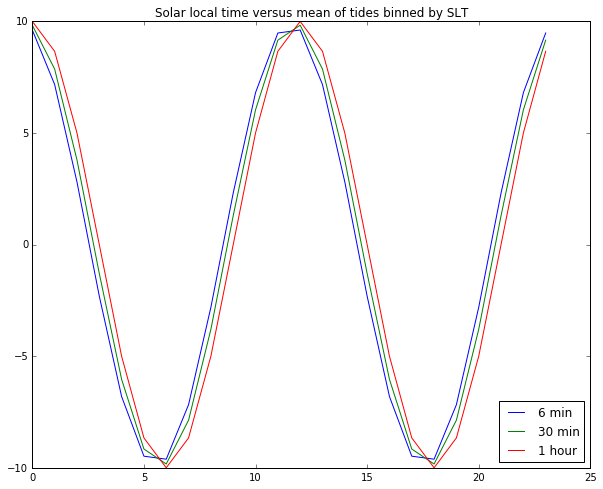

In [11]:
mean6min = [ 9.61410212,  7.17198582,  2.80814171, -2.30814171, -6.80596042, -9.48012753,
 -9.61410212, -7.17198582, -2.80814171,  2.30814171,  6.80596042,  9.48012753,
  9.61410212,  7.17198582,  2.80814171, -2.30814171, -6.80596042, -9.48012753,
 -9.61410212, -7.17198582, -2.80814171,  2.30814171,  6.80596042,  9.48012753]

mean30min = [ 9.82962913,  7.86566092,  3.79409523, -1.29409523, -6.03553391, -9.15975615,
 -9.82962913, -7.86566092, -3.79409523,  1.29409523,  6.03553391,  9.15975615,
  9.82962913,  7.86566092,  3.79409523, -1.29409523, -6.03553391, -9.15975615,
 -9.82962913, -7.86566092, -3.79409523,  1.29409523,  6.03553391,  9.15975615]

mean1hr = [  1.00000000e+01,  8.66025404e+00,   5.00000000e+00,   1.19434012e-14,
  -5.00000000e+00,  -8.66025404e+00,  -1.00000000e+01,  -8.66025404e+00,
  -5.00000000e+00,  -1.76089401e-14,   5.00000000e+00,   8.66025404e+00,
   1.00000000e+01,   8.66025404e+00,   5.00000000e+00,   1.88335869e-14,
  -5.00000000e+00,  -8.66025404e+00,  -1.00000000e+01,  -8.66025404e+00,
  -5.00000000e+00,  -1.07187544e-14,   5.00000000e+00,   8.66025404e+00]

slt = list(range(0,24))
plt.figure(figsize=(10,8))
plt.plot(slt, mean6min, label='6 min')

plt.plot(slt, mean30min, label='30 min')
plt.plot(slt, mean1hr, label='1 hour')
plt.title('Solar local time versus mean of tides binned by SLT')
plt.legend(loc='lower right')
plt.show()


11:53 am

I have determined that the spikes occuring in the 6 min time step thing occur every hour.

Example data for -120 longitude:

Real data (generated)

    16.0000	               0.0000	            -5.0000
    17.0000	               1.0000	            -8.6603
    18.0000	               2.0000	            -10.0000
    
Failed averages
    16.0000         	   0.0000               -6.8060             
    17.0000                1.0000              	-9.4801    
    18.0000                2.0000               -9.6141   
    
    
Note that all the other datapoints (not on the hour) match fine. 

DO THE THINGS MATCH RIGHT ON THE HOUR WHEN TIMESTEP = 1? CHECK

1:40 pm

Yes, they match on the hour when timestep=1, of course. Here's data from the timestep 0.5:

Real data (generated)

    16.0000	            0.0000	         -5.0000
    16.5000	            0.5000	         -7.0711
    17.0000	            1.0000	         -8.6603
    17.5000	            1.5000	         -9.6593
    18.0000	            2.0000	        -10.0000
    18.5000	            2.5000	         -9.6593
    19.0000	            3.0000	         -8.6603


Averages 

    16.0000             0.0000     		-6.0355             
    16.5000             0.5000     		-7.0711             
    17.0000             1.0000     		-9.1598             
    17.5000             1.5000     		-9.6593             
    18.0000             2.0000     		-9.8296             
    18.5000             2.5000     		-9.6593             
    19.0000             3.0000     		-7.8657         
    
    
As can be seen, again, they fail on the hour. So something is happening every hour, when the timestep is different, to screw things up. What could it be? What is affected by the time step?

going to try and run the simulation again but restricting to one longitude at the beginning.

Same result so at least we know that other longitudes aren't getting mixed in:

<img src="pics/SW2 tide and average over SLT,  by Julian date at -120° Longitude.png" />

Thinking: Since the average is larger in magnitude, but with the same sign, as the real values across the board (more positive when tide is positive, more negative when tide is negative) it almost seems like the code is dividing by the wrong number of values or missing a value.

Okay, just wrote out the means to a file to check (after using bin_by_solar) and they are the wrong ones, so something is **definitely happening between the generation of the original data and the creation of the mean values. meaning it is definitely in bin_by_solar**

    0.0000              	-120.0000           	9.6141              
    1.0000              	-120.0000           	7.1720              
    2.0000              	-120.0000           	2.8081              
    3.0000              	-120.0000           	-2.3081             
    4.0000              	-120.0000           	-6.8060             
    5.0000              	-120.0000           	-9.4801             
    6.0000              	-120.0000           	-9.6141             
    7.0000              	-120.0000           	-7.1720             
    8.0000              	-120.0000           	-2.8081             
    9.0000              	-120.0000           	2.3081              
    10.0000             	-120.0000           	6.8060              
    11.0000             	-120.0000           	9.4801              
    12.0000             	-120.0000           	9.6141              
    13.0000             	-120.0000           	7.1720              
    14.0000             	-120.0000           	2.8081              
    15.0000             	-120.0000           	-2.3081             
    16.0000             	-120.0000           	-6.8060             
    17.0000             	-120.0000           	-9.4801             
    18.0000             	-120.0000           	-9.6141             
    19.0000             	-120.0000           	-7.1720             
    20.0000             	-120.0000           	-2.8081             
    21.0000             	-120.0000           	2.3081              
    22.0000             	-120.0000           	6.8060              
    23.0000             	-120.0000           	9.4801      

The problem may be

That since the bin is defined by the hour value, the average for the hour is affected by the values at the partial hours

But then when you subtract it off the original data later you are only matching the exact slt... but you SHOULD be matching the hour value, not the hour and minute value!

that doesn't explain why the mean doesn't match

is that it doesn't match because it is calculated over *more values* which are not exactly the value at the hour. of COURSE It doesn't match. That's why it's going wrong in the bin function too-- we are only assigning these averages to the hour value. If we want the plot to look reasonable we have to take the average for SLT X and subtract it from any original data point with SLT == X.y where y is any value at all.

So at this part in remove_solar:

        # these next two lines may be redundant but it's just to avoid any
        # possible precision errors
        col0 = np.around(original[:, 0], decimals=4)
        col2 = np.around(original[:, 2], decimals=4)
        
what we actually need to do is set decimals = 0 I think.

In [14]:
a = [1.5555, 1.6245, 2.3333, 0.1335, 4.5000, 9.9999]

print(np.around(a, decimals=1))

[  1.6   1.6   2.3   0.1   4.5  10. ]


No that's actually wrong, we really do what the truncate function, not a rounding function. numpy.trunc will do the trick.

In [13]:
a = [1.5555, 1.6245, 2.3333, 0.1335, 4.5000, 9.9999, -3.4444, -0.0485, 10.0000]
print(np.trunc(a))

# Check the "-0" thing isn't a problem
b = np.trunc(a)

b[7]==0

[  1.   1.   2.   0.   4.   9.  -3.  -0.  10.]


True

Okay here is what I get when I change that and run it again, with a bin size of 1 hour:

<img src="pics/SW2 tide and average over SLT,  -120° Longitude.png" />

For lunar tides:

<img src="pics/M2 tide and average over SLT, at -120° Longitude.png" />

In [11]:
a = [0,0.1,0.2,0.5,0.6,0.9,1,1.2,1.5,2]

print(np.around(a, decimals=1))

1.2%0.5

[ 0.   0.1  0.2  0.5  0.6  0.9  1.   1.2  1.5  2. ]


0.19999999999999996

Try it with bin size 30 minutes..


Oops, need some new code first for the binning.



In [22]:
binsize = 0.5
original = np.asarray(list(np.arange(12,15,0.1)))

if binsize == 1:
    col0 = np.trunc(original)
elif binsize == 0.5:
    col0 = np.zeros([original.size])
    for entry in range(original.size):
        time = original[entry]
        if time % 0.5 == 0:
            col0[entry] = time
        else:
            modifier = time - int(time)
            if modifier > 0.5:
                modifier -= 0.5
            col0[entry] = time - modifier
     
print(original)
print(col0)

[ 12.   12.1  12.2  12.3  12.4  12.5  12.6  12.7  12.8  12.9  13.   13.1
  13.2  13.3  13.4  13.5  13.6  13.7  13.8  13.9  14.   14.1  14.2  14.3
  14.4  14.5  14.6  14.7  14.8  14.9]
[ 12.   12.   12.   12.   12.   12.   12.5  12.5  12.5  12.5  12.5  13.
  13.   13.   13.   13.   13.5  13.5  13.5  13.5  13.5  14.   14.   14.
  14.   14.   14.5  14.5  14.5  14.5]


4:30 pm
    
Updates!

I fixed the binning to do bin = 30 minutes and it looks even nicer. See below..

<img src="pics/SW2 tide and average over SLT, bin=30min, at -120° Longitude.png" />

<img src="pics/M2 tide and average over SLT, bin=30min, at -120° Longitude.png" />

Now the challenge is to figure out why we get jigs again in the lunar view there. Again, it's only in the SLT, so it's probably just due to that--the SLT doesn't perfectly correspond to the full lunar cycle.

On Monday, I'll get back on track on utilizing these results to actually do the analysis originally planned.

To do - with some rough break down since there's only 2 weeks left!

**Monday:**
- Figure out if we can address the jigs in the lunar average over SLT (or if it even matters)
- Re-generate the 4 cases (~1-2 hours)
    - plot the acutal difference after subtraction, too
- implement lunar binning
- compare original amplitude and phase with calculated amplitude and phase (~ 2 hours)
- test sensitivity towards window size (1/2, 3/4, 1 lunar cycle) (~2 hours)


**Tuesday**
- any dependence on relative amplitude magnitude of SW2 and M2 (numerical?) (~1 hour)
- test by adding additional waves (~3 hours)
- compare to least square fitting of total variation or other methods (not identified yet) (~4 hours at least)

**Wednesday - Thursday**
- B. TIMEGCM case
     - analyze latitudinal and temporal variation (???)
     - vertical wavelength
     
**Friday**
- Examine separation of lunar tide from 16 day oscillation
    - issue with synthetic data?
    - numerical model (could add artificial quasi 16 day oscillation)
    - satellite data (if there is time)

# July 11 2016

Let's start today by plotting the total tides (reconstructed) and then do the lunar binning.


<img src="pics/SW2+M2 total and average, bin=30min, at -120° Longitude.png" />

Okay, this doesn't look like much, probably for 2 reasons
1. Need to do the lunar binning
2. Stupid jigs

It occurs to me it's also more useful to plot it against the original fed in lunar tide:

<img src="pics/Original and reconstructed M2, bin=30min, at -120° Longitude.png" />

yeah also not so great.

10:16 am 

Aha, Astrid reminded me that you have to plot these things over a lunar cycle to show improvement. Indeed when we plot over 30 days the two look very good!

<img src="pics/Original and reconstructed M2,1 lunar cycle, bin=30min, at -120° Longitude.png" />

Here is a 14.5 day window, since it should be similar:

<img src="pics/Original and reconstructed M2, half lunar cycle, bin=30min, at -120° Longitude.png" />

It's a little hard to see in these images as displayed in the notebook, but there is a little bit of wonkyness at the maxima around the reconstructed data. I will zoom in and post a screenshot for clarity, and then work on the lunar binning.

<img src="pics/wonkymaxwholecycle.png" />

<img src="pics/wonkymax.png" />

Also one more, here is the same plot for bin of 1 hour.

<img src="pics/Total SW2+M2 and total - SLT avg, half lunar cycle, bin=1 hr, at -120° Longitude.png" />

## Lunar binning

For lunar binning, I basically copied the script of solar binning but altered it slightly. Also, instead of using the means generated by the lunar binning as values to subtract from the totals, I instead replaced the tidal values at various matching SLT and longitudes with those averages completely. Here's the result for a bin size of 30 minutes:

<img src="pics/Original and reconstructed M2 after LLT bin, half lunar cycle, bin=30 min at -120° Longitude.png" />

and 1 hour:

<img src="pics/Original and reconstructed M2 after LLT bin, half lunar cycle, bin=1 hr at -120° Longitude.png" />

Looking very good! Only a few small jumps... may be that replacing with the average isn't reasonable but I can ask Astrid after lunch.

BTW, the hour-bin runs so much faster (at least 4 times) than the 30 minute bin. It would be nice to run these on the desktops if possible. Then again those don't look very powerful either... eh, yeah, I just checked and it has less memory than my laptop. Oh well.

Recap of the to-do list before lunch.

Monday:

- <s>Figure out if we can address the jigs in the lunar average over SLT (or if it even matters)</s>
- Re-generate the 4 cases (~1-2 hours)
- <s>plot the acutal difference after subtraction, too</s>
- <s>implement lunar binning</s>
- compare original amplitude and phase with calculated amplitude and phase (~ 2 hours)
- test sensitivity towards window size (1/2, 3/4, 1 lunar cycle) (~2 hours)

12:40 pm

## Notes from meeting with Astrid

2:37 pm

Inserting the averages into the data structure that was generated is fine for a visual comparison to see what we get. But, the main goal is to plot the LLT average versus local time.

The amplitude and phase we get out should compare to what was originally fed in. we don't need to worry about the other columns of information (SLT, julian date, moon phase) because they're not relevant at that point. 

do the least squares by using the original and calculated values. 

3:44 pm

Have been working on writing a nice and tidy script for scenario 1 (background = 0, constant amplitude and phase) and making sure everything writes out files for analysis properly; this is because it seems like the analysis is really going to be a second part to the project. Once the data and the lunar binned stuff gets generated, I don't really care where it came from, and I want to do separate analysis with separate scripts on it. Thus I'm making everything involved in data generation and binning and substracting fairly self-contained.

I just finished making a good version of the caling script, so I'm now letting it run to generate the data files for a bin size of 0.5 hour (which takes a few minutes for each run). Then I'll do the other 3 scenarios.

**NOTE: TO FIX**

I am still getting this error when I use a bin size of 0.5 hour. It doesn't stop the script and things seem pretty okay data-wise but the error does exist.

    /home/emc/GoogleDrive/School/Research/LASP/Lunar Tides Project/solar_extraction.py:306: RuntimeWarning: invalid value encountered in true_divide
      slt_means = slt_sum / slt_vals
      
4:17 pm

Just decided to print out the slt_sum and slt_vals variables to see if I could figure out why I was getting that error. Here's one example of each:

    [ 162.89507382    0.          141.57437084    0.           82.2958887     0.
        0.96272635    0.          -80.6115909     0.         -140.55313048
        0.         -162.79270308    0.         -141.37356837    0.
      -82.04695384    0.           -0.7280152     0.           80.77328515
        0.          140.56850616    0.          163.17067663    0.
      142.01946057    0.           82.79897409    0.            1.39778872
        0.          -80.35353105    0.         -140.53671499    0.
     -163.02204389    0.         -141.79121752    0.          -82.5482937     0.
       -1.18746434    0.           80.47081492    0.          140.53142647
        0.        ]
    [ 15.   0.  15.   0.  15.   0.  15.   0.  15.   0.  15.   0.  15.   0.  15.
       0.  15.   0.  15.   0.  15.   0.  15.   0.  15.   0.  15.   0.  15.   0.
      15.   0.  15.   0.  15.   0.  15.   0.  15.   0.  15.   0.  15.   0.  15.
       0.  15.   0.]
       
So... unfortunately it looks like there is a screw up in my algorithm of using 30 minute bins. It's not finding the values at all for the non-integer numbered bins.

I'll go ahead and generate all the hour-bin data files and then return to this problem later.

Note to self: What's probably happening is the code

    i = int(row[0] * 2)
    
is wrong.

4:23 pm

Aha, found the problem. that row assumed the timestep is 0.5. But when it's 0.25 we have a problem:

    Row[0]
    10.25
    
    i:
    20.5
    
    Row[0]
    10.5
    
    i:
    21.0
    
    Row[0]
    10.75
    
    i:
    21.5
    
and then doing int() on these converted them down to the nearest whole number so we got doubles of things. So this step needs to depend on the timestep actually.

Actually I want to fix this before I move on.

4:43 pm

Just more carefully read the documentation for numpy.digitize and realized it is probably what I want. What follows is testing.

In [21]:
binsize = 0.5

output = np.zeros([int(24 / binsize), 3])
bins = list(np.arange(0, 24, binsize))
        
output[:,0] = bins

times = np.array(np.arange(0,24,0.25))
print('Times')
print(times)
print()

tides = np.array([5]*len(times))
tides[1] = 3
tides[2] = 69
tides[-1] = 43
print('Tides')
print(tides)
print()

print('Index in output time column in which each value in times belongs')
inds = np.digitize(times, bins)
inds = inds -1
print(inds)

for i,j in zip(inds, tides):
    output[i,1] += j
    output[i,2] += 1
    
print(output)


Times
[  0.     0.25   0.5    0.75   1.     1.25   1.5    1.75   2.     2.25
   2.5    2.75   3.     3.25   3.5    3.75   4.     4.25   4.5    4.75   5.
   5.25   5.5    5.75   6.     6.25   6.5    6.75   7.     7.25   7.5
   7.75   8.     8.25   8.5    8.75   9.     9.25   9.5    9.75  10.    10.25
  10.5   10.75  11.    11.25  11.5   11.75  12.    12.25  12.5   12.75  13.
  13.25  13.5   13.75  14.    14.25  14.5   14.75  15.    15.25  15.5
  15.75  16.    16.25  16.5   16.75  17.    17.25  17.5   17.75  18.    18.25
  18.5   18.75  19.    19.25  19.5   19.75  20.    20.25  20.5   20.75  21.
  21.25  21.5   21.75  22.    22.25  22.5   22.75  23.    23.25  23.5
  23.75]

Tides
[ 5  3 69  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5 43]

Index in output tim

Okay that looks great. Next step is to implement it but it's already 5 pm so we have to go home now.

7:00 pm
    
Fixed the binning function mostly. It functions fine for binsize = 1 and doesn't produce the error. But it still produces the error for dt = 0.25 when binsize is 0.5. 

7:15 pm

Actually I think the error occurs for dt = 1.0 when bin size is 0.5. This is because with bins

    0   0.5   1   1.5   ...
    
But times

    0    1    2    3    ...
    
you will get a 0 every time you hit a bin that is a decimal. The takeaway is...



**<font size=40>bin size must be greater than or equal to the step size!</font>**

7:18 pm

Just confirmed it's for dt = 1. I don't really think there is a way to address this other than putting in some error control.

8:00 pm

Okay I'm running out of time to go lift so I'm going to do that. One thing I noticed in trying to generate the cases (see below) is that I'm passing the same phi to both solar and lunar tides when I generate the sum (s+l). I need to be able to separate that so it's something I should fix later.

## Plots for Scenarios 1-4 

### Scenario 1, bin size = 1 hour, window = 15 days

<img src="pics/Original and reconstructed M2, half lunar cycle, bin=60 min, sc1 at -180° Longitude.png" />

### Scenario 1, bin size = 30 minutes, window = 15 days

<img src="pics/Original and reconstructed M2, half lunar cycle, bin=30 min, sc1 at -180° Longitude.png" />

### Scenario 2, bin size = 60 minutes, window = 15 days

<img src="pics/Original and reconstructed M2, half lunar cycle, bin=60 min, sc2 at -180° Longitude.png" />

### Scenario 2, bin size = 30 minutes, window = 15 days

<img src="pics/Original and reconstructed M2, half lunar cycle, bin=30 min, sc2 at -180° Longitude.png" />

### Scenario 3, bin size = 60 minutes, window = 15 days

<img src="pics/Original and reconstructed M2, half lunar cycle, bin=60 min, sc3 at -180° Longitude.png" />

### Scenario 3, bin size = 30 minutes, window = 15 days

### Scenario 4, bin size = 60 minutes, window = 15 days

### Scenario 4, bin size = 30 minutes, window = 15 days